### **Loading in data**

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

import pickle

def load_phsp():
    with open('phsp_evts.pkl', 'rb') as f:
        phsp_evts = pickle.load(f)
        phsp_t = pickle.load(f)
        phsp_wgts = pickle.load(f)
        phsp_dcs_amps = pickle.load(f)
        phsp_cf_amps = pickle.load(f)
    return phsp_evts, phsp_t, phsp_wgts, phsp_dcs_amps, phsp_cf_amps

def load_sig():
    with open('sig_evts_non_smeared.pkl', 'rb') as f:
        sig_evts = pickle.load(f)
        sig_t = pickle.load(f)                                                                                                  
        sig_wgts = pickle.load(f)
        sig_dcs_amps = pickle.load(f)
        sig_cf_amps = pickle.load(f)
    return sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps

def load_nomix_sig():
    with open('sig_evts_no_mix.pkl', 'rb') as f:
        sig_evts = pickle.load(f)
        sig_t = pickle.load(f)
        sig_wgts = pickle.load(f)
        sig_dcs_amps = pickle.load(f)
        sig_cf_amps = pickle.load(f)
    return sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps

def load_mistag():
    with open('mistag_evts.pkl', 'rb') as f:
        mistag_evts = pickle.load(f)
        mistag_t = pickle.load(f)
        mistag_wgts = pickle.load(f)
        mistag_dcs_amps = pickle.load(f)
        mistag_cf_amps = pickle.load(f)
    return mistag_evts, mistag_t, mistag_wgts, mistag_dcs_amps, mistag_cf_amps
    
#phsp_evts, phsp_t, phsp_wgts, phsp_dcs_amps, phsp_cf_amps = load_phsp()
sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps = load_sig()
#nomix_evts, nomix_t, nomix_wgts, nomix_dcs_amps, nomix_cf_amps = load_nomix_sig()
#mistag_evts, mistag_t, mistag_wgts, mistag_dcs_amps, mistag_cf_amps = load_mistag()


### **The smearing class**

In [4]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import scipy
import vector
import pandas as pd
from iminuit import Minuit
from math import log10, floor
from scipy import integrate
from scipy.stats import crystalball

class Smearing:
    """
    Class to smear generated data from AmpGen.
    - The branch of a certain LHCb simulation file needs to be initialized, this can be branch in 2016-2018 MagUp/MagDown
    - The AmpGen generated signal data needs to be initialized
    - The type, this decides if the momenta are taken from the "LabFrame" or the "D0Frame".
    - The bound with which the relative momenta are cut. 0.1 is recommended in the D0 frame, and 0.04 in Labframe. Then the most of the data is kept and
    the big outliers are cut.
    """

    def __init__(self, branch, data, type = "D0Frame",  bounds = 0.04):
        self.branch = branch
        self.data = data # sig_evts
        self.fitted_values = []
        self.data_for_smearing = [[],[],[],[]] # 4 entries such that I can create datasets for K, pi os1, pi os2, pi ss
        
        self.bounds = bounds #This is where it is cut to keep outliers out.
        self.kaon_mass = 493.677 #MeV
        self.pion_mass = 139.57039 #MeV
        self.D0_mass = 1864.84 #MeV
        self.smeared_phase_space = []
        self.smeared_sig_evts = []
        self.type = type
        
    def rec_four_vector(self):
        # Creating the reconstructed four vectors for the decay products using the LHCb simulation file branch.
        branch = self.branch
        p_k = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_PX']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_PY']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_PZ']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_PE'])})

        # Actually OS.
        p_pi_os1 = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_PX']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_PY']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_PZ']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_PE'])})

        # Actually OS.
        p_pi_os2 = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_PX']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_PY']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_PZ']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_PE'])})

        # Actually SS.
        p_pi_ss = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_PX']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_PY']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_PZ']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_PE'])})

        if self.type == "D0Frame":
            
            p_d0 = p_k + p_pi_ss + p_pi_os1 + p_pi_os2

            # Boost to D0 rest frame.
            p_k = p_k.boostCM_of(p_d0)
            p_pi_ss = p_pi_ss.boostCM_of(p_d0)
            p_pi_os1 = p_pi_os1.boostCM_of(p_d0)
            p_pi_os2 = p_pi_os2.boostCM_of(p_d0)
            
        return p_k, p_pi_os1, p_pi_os2, p_pi_ss

    def true_four_vector(self):
        # Creating the true four vectors for the decay products using the LHCb simulation file branch.
        branch = self.branch
        p_k = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_TRUEP_X']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_TRUEP_Y']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_TRUEP_Z']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P0_TRUEP_E'])})

        # Actually OS.
        p_pi_os1 = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_TRUEP_X']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_TRUEP_Y']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_TRUEP_Z']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P1_TRUEP_E'])})

    # Actually OS.
        p_pi_os2 = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_TRUEP_X']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_TRUEP_Y']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_TRUEP_Z']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P3_TRUEP_E'])})

    # Actually SS.
        p_pi_ss = vector.arr({
            'px' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_TRUEP_X']), 
            'py' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_TRUEP_Y']),
            'pz' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_TRUEP_Z']),
            'e' : uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_P2_TRUEP_E'])})

        if self.type == "D0Frame":
            
            p_d0 = p_k + p_pi_ss + p_pi_os1 + p_pi_os2

            # Boost to D0 rest frame.
            p_k = p_k.boostCM_of(p_d0)
            p_pi_ss = p_pi_ss.boostCM_of(p_d0)
            p_pi_os1 = p_pi_os1.boostCM_of(p_d0)
            p_pi_os2 = p_pi_os2.boostCM_of(p_d0)
            
        return p_k, p_pi_os1, p_pi_os2, p_pi_ss
        
    def AmpGen_four_vector(self):
        # Creating the four vectors from the generated AmpGen signal data. This is always in the D0Frame.
        data = self.data
        p_k = vector.arr({
            'px' : data[:, 0], 
            'py' : data[:,1] ,
            'pz' : data[:,2] ,
            'e' : data[:,3] })

        # Actually OS.
        p_pi_os1 = vector.arr({
            'px' : data[:, 4], 
            'py' : data[:,5] ,
            'pz' : data[:,6] ,
            'e' : data[:,7] })

    # Actually OS.
        p_pi_os2 = vector.arr({
            'px' : data[:, 8], 
            'py' : data[:,9] ,
            'pz' : data[:,10] ,
            'e' : data[:,11] })

    # Actually SS.
        p_pi_ss = vector.arr({
            'px' : data[:, 12], 
            'py' : data[:,13] ,
            'pz' : data[:,14] ,
            'e' : data[:,15] })
        return p_k, p_pi_os1, p_pi_os2, p_pi_ss
        
    def truth_matching(self, four_vector):
        """
        Function where four four vectors need to be entered, and they are returned truthmatched. Hence, only the signal entries are returned.
        """
        p_k, p_pi_os1, p_pi_os2, p_pi_ss = four_vector
        
        truth_matched = uproot.models.TBranch.Model_TBranch_v12.array(self.branch['D0_BKGCAT']) == 0
        p_k = p_k[truth_matched]
        p_pi_os1 = p_pi_os1[truth_matched]
        p_pi_os2 = p_pi_os2[truth_matched]
        p_pi_ss = p_pi_ss[truth_matched]
        return p_k, p_pi_os1, p_pi_os2, p_pi_ss
        
    def Data_remover(self, data):
        """
        Using the initialised bounds, the relative four vectors can be cut. For a certain decay, if one if the decay products has a relative resolution
        that is outside the bounds, that entire decay entry is removed.
        """

        bounds = self.bounds
        pd_data = pd.DataFrame(data).T
        mask_0 = np.logical_and(data[0] > -bounds, data[0] < bounds)
        mask_1 = np.logical_and(data[1] > -bounds, data[1] < bounds)
        mask_2 = np.logical_and(data[2] > -bounds, data[2] < bounds)
        mask_3 = np.logical_and(data[3] > -bounds, data[3] < bounds)

        mask = mask_0  * mask_1 * mask_2 * mask_3
        print(f"Number of points initially {len(mask)}, number of points after cut {np.sum(mask)}")
        masked_data = pd_data[mask]
        return np.array(masked_data.T)

    def momentum_magnitude_particles(self, type = None):
        """
        From the reconstructed and true four vectors, in this function the relative resolution of the magnitude is calculated.
        This is done by (p_true - p_rec)/p_true. 
        If type == "Split", the relative resolution is split into four bins of the original magnitudes, this can be used to see if the relative
        resolution increase as the momentum increases.
        """
        branch = self.branch
        truth_matched = uproot.models.TBranch.Model_TBranch_v12.array(branch['D0_BKGCAT']) == 0
        
        four_K_p_t, four_pi_os1_p_t, four_pi_os2_p_t, four_pi_ss_p_t = self.truth_matching(self.true_four_vector()) # Getting only signal true four vectors
        four_K_p, four_pi_os1_p, four_pi_os2_p, four_pi_ss_p = self.truth_matching(self.rec_four_vector())
        
        K_p = four_K_p.mag
        K_p_true = four_K_p_t.mag

        pi_os1_p = four_pi_os1_p.mag
        pi_os1_p_true = four_pi_os1_p_t.mag

        pi_os2_p = four_pi_os2_p.mag
        pi_os2_p_true = four_pi_os2_p_t.mag

        pi_ss_p = four_pi_ss_p.mag
        pi_ss_p_true = four_pi_ss_p_t.mag

        diff_true_rec_p = np.array([K_p_true - K_p, pi_os1_p_true - pi_os1_p , pi_os2_p_true - pi_os2_p, pi_ss_p_true - pi_ss_p])
        true_p = np.array([K_p_true, pi_os1_p_true , pi_os2_p_true, pi_ss_p_true])
        rec_p = np.array([K_p, pi_os1_p , pi_os2_p, pi_ss_p])
        
        relative_diff_true_rec_p = []
        for i in range(4):
            relative_diff_true_rec_p.append(diff_true_rec_p[i]/true_p[i])


        if type == "Split":
            n_bins = 4
            rec_p_cut = []
            rel_dp_cut = []
            for i in range(4):
                bins_id = pd.qcut(rec_p[i], n_bins, labels = False)
                current_particle_p = []
                current_particle_dp_cut = []
                for j in range(n_bins):
                    current_particle_p.append(rec_p[i][bins_id == j])
                    current_particle_dp_cut.append(relative_diff_true_rec_p[i][bins_id == j])
                rec_p_cut.append(current_particle_p)
                rel_dp_cut.append(current_particle_dp_cut)
            return rec_p_cut, rel_dp_cut
                    
        relative_diff_true_rec = self.Data_remover(relative_diff_true_rec_p) #The cut rel_diff_true_rec_p

        return np.array(relative_diff_true_rec)

    def individual_momenta_data(self):
        """
        From the reconstructed and true four vectors, in this function the relative resolution of the individual vector components is calculated.
        This is done by e.g. (p_x_true - p_x_rec)/p_x_true. 
        """
        p_k_t, p_pi_os1_t, p_pi_os2_t, p_pi_ss_t = self.truth_matching(self.true_four_vector()) #The true fourvectors
        p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.truth_matching(self.rec_four_vector()) # The reconstructed fourvectors

        
        diff_true_rec_k = np.array([p_k_t.E - p_k.E, p_k_t.px - p_k.px, p_k_t.py - p_k.py, p_k_t.pz - p_k.pz])
        diff_true_rec_pi_os1 = np.array([p_pi_os1_t.E - p_pi_os1.E, p_pi_os1_t.px - p_pi_os1.px, p_pi_os1_t.py - p_pi_os1.py, p_pi_os1_t.pz - p_pi_os1.pz])
        diff_true_rec_pi_os2 = np.array([p_pi_os2_t.E - p_pi_os2.E, p_pi_os2_t.px - p_pi_os2.px, p_pi_os2_t.py - p_pi_os2.py, p_pi_os2_t.pz - p_pi_os2.pz])
        diff_true_rec_pi_ss = np.array([p_pi_ss_t.E - p_pi_ss.E, p_pi_ss_t.px - p_pi_ss.px, p_pi_ss_t.py - p_pi_ss.py, p_pi_ss_t.pz - p_pi_ss.pz])

        diff_true_rec_p = np.array([diff_true_rec_k, diff_true_rec_pi_os1, diff_true_rec_pi_os2, diff_true_rec_pi_ss])
        
        true_p = np.array([[p_k_t.E, p_k_t.px, p_k_t.py,p_k_t.pz], [p_pi_os1_t.E, p_pi_os1_t.px, p_pi_os1_t.py, p_pi_os1_t.pz], [p_pi_os2_t.E, p_pi_os2_t.px, p_pi_os2_t.py, p_pi_os2_t.pz], [p_pi_ss_t.E, p_pi_ss_t.px, p_pi_ss_t.py, p_pi_ss_t.pz]])

        relative_diff_true_rec_all = diff_true_rec_p/true_p
        
        relative_diff_true_rec_outliers_rm = []
        for i in range(4):
            relative_diff_true_rec_outliers_rm.append(self.Data_remover(relative_diff_true_rec_all[i])) #The cut rel_diff_true_rec_p
            
        return relative_diff_true_rec_outliers_rm

    def gaussian(self, x, mean, sigma): #Just normal distribution
        return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5* ((x-mean)/sigma)**2)

    def normalized_gaussian(self, mean, sigma): # Normal distribution normalized on set bounds, by dividing by integral
        
        Pvalue, error = integrate.quad(self.gaussian, -self.bounds, self.bounds, args = (mean, sigma))
        return 1/Pvalue * self.gaussian(self.data_to_fit, mean, sigma) # Self.data_to_fit is the current data to fit e.q. relative momentum magnitude of the Kaon 

    def normalized_double_gaussian(self, mean, sigma_1, sigma_2, fraction): # Double gaussian function, 1 mean two standard deviations
        
        norm_gaussian_1 = self.normalized_gaussian(mean, sigma_1)
        norm_gaussian_2 = self.normalized_gaussian(mean, sigma_2)
        return fraction * norm_gaussian_1 + (1-fraction)* norm_gaussian_2

    def log_like_hood_double_gaussian(self, mean, sigma_1, sigma_2, fraction): #Log-likelihood of the double gaussian
        return - np.sum(np.log(self.normalized_double_gaussian(mean, sigma_1, sigma_2, fraction)))

    def double_gaussian_fit(self):
        # Fits the double gaussian using Minuit.
        
        fit_double_gaussian = Minuit(self.log_like_hood_double_gaussian, mean = 0, sigma_1 = np.std(self.data_to_fit), sigma_2 = np.std(self.data_to_fit)/2, fraction = 0.3)
        fit_double_gaussian.limits["sigma_1"] = (0, np.inf)
        fit_double_gaussian.limits["sigma_2"] = (0, np.inf)
        fit_double_gaussian.limits["fraction"] = (0,1)
        fit_double_gaussian.errordef = Minuit.LIKELIHOOD
        fit_double_gaussian.migrad()
        fit_double_gaussian.hesse()
        if fit_double_gaussian.valid == True:
            return fit_double_gaussian
        else:
            print("Wrong fit")

    def round(self, x, sig=2):
        #Function that rounds to a certain amount of significant digits. 2 is the standard
        return round(x, sig-int(floor(log10(abs(x))))-1)

    def mean_average_sigma(self, fitted_values, fitted_values_err):
        # Function that returns rounded mean and the rounded effective standard deviation sigma_eff = x * sigma_1 + (1-x) * sigma_2
        # Also return the error on both
        
        fitted_values = np.array(fitted_values)
        fitted_values_err = np.array(fitted_values_err)
        means = fitted_values[0]
        means_err = fitted_values_err[0]

        average_sigma = fitted_values[1] * fitted_values[3] + fitted_values[2]*(1-fitted_values[3])
        average_sigma_err = np.sqrt((fitted_values[3] * fitted_values_err[1])**2 + ((1-fitted_values[3])*fitted_values_err[2])**2 + ((fitted_values[1]-fitted_values[2])*fitted_values_err[3])**2)

        return self.round(means), self.round(means_err), self.round(average_sigma), self.round(average_sigma_err)

    
    def plot_fits(self, type): 
        
        #Function that fits the type that is specified, and then plots the resulting fit with the data that is fitted.
        
        n_bins = 60
        if type == "Magnitude":
            bounds = [self.bounds, self.bounds, self.bounds, self.bounds]
            names = ["Kaon " + r"$\frac{\delta p}{p}$",  "Pion os 1 " + r"$\frac{\delta p}{p}$",
                     "Pion os 2 " + r"$\frac{\delta p}{p}$", "Pion ss " + r"$\frac{\delta p}{p}$"]
            rel_diff_true_rec_p = self.momentum_magnitude_particles()
            
        elif type == "Kaon":
            bounds = [self.bounds, self.bounds, self.bounds, self.bounds]
            names = ["Kaon PE", "Kaon PX", "Kaon PY", "Kaon PZ"] 
            rel_diff_true_rec_p = self.individual_momenta_data()[0]  
            
        elif type == "Pion os1":
            bounds = [self.bounds, self.bounds, self.bounds, self.bounds]
            names = ["Pion os1 PE", "Pion os1 PX", "Pion os1 PY", "Pion os1 PZ"] 
            rel_diff_true_rec_p = self.individual_momenta_data()[1] 
            
        elif type == "Pion os2":
            bounds = [self.bounds, self.bounds, self.bounds, self.bounds]
            names = ["Pion os2 PE", "Pion os2 PX", "Pion os2 PY", "Pion os2 PZ"] 
            rel_diff_true_rec_p = self.individual_momenta_data()[2] 
            
        elif type == "Pion ss":
            bounds = [self.bounds, self.bounds, self.bounds, self.bounds]
            names = ["Pion ss PE", "Pion ss PX", "Pion ss PY", "Pion ss PZ"] 
            rel_diff_true_rec_p = self.individual_momenta_data()[3] 

        elif type == "Phase_space":
            bounds = [0.1, 20, 20, 0.05, 0.05]
            names = names = [r"$\phi$ (radians)", "m_kpi (MeV)", "m_pipi (MeV)", r'cos ($\theta_1$)', r"cos ($\theta_2$)"] 
            
            phase_space = np.array(self.phase_space_variables("AmpGen"))
            smeared_phase_space = np.array(self.smeared_phase_space)[:, 0:5]
            
            rel_diff_true_rec_p =  [phase_space[0][0:10000] - smeared_phase_space[:,0], phase_space[1][0:10000] - smeared_phase_space[:,1], phase_space[2][0:10000] - smeared_phase_space[:,2], phase_space[3][0:10000] - smeared_phase_space[:,3], phase_space[4][0:10000] - smeared_phase_space[:,4]] # To plot individual momenta 
        
        fig, ax = plt.subplots(1,len(names), figsize  = (20,6))
        
        for i in range(len(names)):
            self.bounds = bounds[i]         
            self.data_to_fit = rel_diff_true_rec_p[i] #Set the data that is going to fit according to the type
            
            double_gaussian_fit = self.double_gaussian_fit() # the fitted double gaussian using the self.data_to_fit()
            mean, sigma1, sigma2, fraction = double_gaussian_fit.values
            self.fitted_values.append(double_gaussian_fit.values)
            
            t = np.linspace(-self.bounds, self.bounds, 10000) # Just a lot of points for the plot
            self.data_to_fit = t #To make the plots, this will go into the double gaussian function
            
            double_gaussian_outcome = self.normalized_double_gaussian(*double_gaussian_fit.values)
            mean, mean_err, sigma, sigma_err = self.mean_average_sigma(double_gaussian_fit.values, double_gaussian_fit.errors)
            
            ax[i].plot(t, double_gaussian_outcome , label = r"$\mu = $" + f"{mean} \n \u00B1 {mean_err} \n" 
                 +r"$\sigma_{eff} = $" + f"{sigma} \n \u00B1 {sigma_err}", color = 'r', linewidth = 2)
            ax[i].hist(rel_diff_true_rec_p[i], bins = n_bins, density = True, alpha = 0.5)
            ax[i].set_xlabel(names[i], fontsize = 15)
            ax[i].legend(loc = "upper right", fontsize = 13)
        
        ax[0].set_ylabel("Normalized counts", fontsize = 15)
        fig.tight_layout()

        plt.show()
    
    def box_method_magnitude(self, number_of_points = 10000, factor = 2, sigma = 0.004*np.pi): 
        """
        Function used to smear AmpGen data using the magnitudes of the momenta of the decay particles.
        - I generated 1.000.000 AmpGen points, hence I smeared all 1.000.000 points, but to just check what it does you can set the amount of points
        - If this is done in the D0 frame, the magnitudes of the momenta are smeared by fitting the relative magnitudes resolution.
        To get the resolution on the angular phase space variables, the direction of the four vectors is changed. In the D0 frame this is done by estimating
        the angle between the kaon true and reconstructed four vectors. This is fitted with a CrystalBall function where then random numbers are taken from.
        - In the LabFrame, the magnitudes of the momenta are smeared by fitting the relative magnitude resolution, but then multiplying the smearing numbers
        by a certain factor that can be set. Then the direction of the particles is smeared with a gaussian, the sigma of the gaussian can also be set.
        
        """
        self.plot_fits("Magnitude") #To set the fits of the things

        if self.type == "D0Frame":
            # Getting the CrystalBall function to get random numbers from for the smearing of the direction of the four vectors.
            p_k, p_pi1, p_pi2, p_pi3 = self.truth_matching(self.rec_four_vector())
            p_k_t, p_pi1_t, p_pi2_t, p_pi3_t = self.truth_matching(self.true_four_vector())
            angle = -1* p_k.deltaangle(p_k_t)
            fit_values = crystalball.fit(angle)
            bins = np.linspace(0, 0.05, 100)
            t = np.linspace(-0.05, 0, 10000)
            plt.hist(p_k.deltaangle(p_k_t), bins = bins, density = True, alpha = 0.6)
            plt.plot(-1* t, crystalball.pdf(t, fit_values[0], fit_values[1], fit_values[2], fit_values[3]))
            plt.xlabel(r" $\rho$ (radians)")
            plt.ylabel("Normalized counts")
            plt.show()

        

        p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.AmpGen_four_vector()
        vector_list = [p_k, p_pi_os1, p_pi_os2, p_pi_ss]
        for i in range(number_of_points):
            if i % 10000 == 0:
                print(f"Currently at point {i} of 1.000.000")
            incorrect_smear = True
            while incorrect_smear:
                smear_number = [10000, 10000, 10000, 10000] # arbitrary number, for [Kaon, pion os1, pion os2, pion ss]
                for j in range(4):
                    self.data_to_fit = np.linspace(-self.bounds, self.bounds, 100000)
                    Fmax = np.max(self.normalized_double_gaussian(*self.fitted_values[j])) # Getting the max of the resolution functions.
                    while(smear_number[j] == 10000): # So stops if the smearing is done and the arbitrary number is changed 
                        self.data_to_fit = np.random.uniform(-self.bounds, self.bounds) # Get a number random in the set bounds
                        y1 = self.normalized_double_gaussian(*self.fitted_values[j])
                        y2 = np.random.uniform(0, Fmax) 
                        if (y2<y1): # See if the number is actually inside the box, otherwise try again.
                            smear_number[j] = self.data_to_fit

                #Smearing the momenta with their magnitudes to create resolution in m_kpi & m_pipi, rotating for phi, cosa and cosb
                
                self.p_k_smeared = p_k[i] * (1-smear_number[0]*factor)
                self.p_k_smeared.E = np.sqrt( self.p_k_smeared.px**2 + self.p_k_smeared.py**2 + self.p_k_smeared.pz**2 + self.kaon_mass**2)
                self.p_pi_os1_smeared = p_pi_os1[i] * (1-smear_number[1]*factor)
                self.p_pi_os1_smeared.E = np.sqrt( self.p_pi_os1_smeared.px**2 + self.p_pi_os1_smeared.py**2 + self.p_pi_os1_smeared.pz**2 + self.pion_mass**2)
                self.p_pi_os2_smeared = p_pi_os2[i] * (1-smear_number[2]*factor)
                self.p_pi_os2_smeared.E = np.sqrt( self.p_pi_os2_smeared.px**2 + self.p_pi_os2_smeared.py**2 + self.p_pi_os2_smeared.pz**2 + self.pion_mass**2)
                self.p_pi_ss_smeared = p_pi_ss[i] * (1-smear_number[3]*factor)
                self.p_pi_ss_smeared.E = np.sqrt( self.p_pi_ss_smeared.px**2 + self.p_pi_ss_smeared.py**2 + self.p_pi_ss_smeared.pz**2 + self.pion_mass**2)

                
                if self.type == "LabFrame":
                    self.p_k_smeared = self.p_k_smeared.rotate_euler(phi = np.random.normal(0, sigma), theta = np.random.normal(0,sigma), 
                                                                     psi = np.random.normal(0, sigma), order = 'zxz')
                    self.p_pi_os1_smeared = self.p_pi_os1_smeared.rotate_euler(phi = np.random.normal(0, sigma), theta = np.random.normal(0,sigma), 
                                                                     psi = np.random.normal(0, sigma), order = 'zxz')
                    self.p_pi_os2_smeared = self.p_pi_os2_smeared.rotate_euler(phi = np.random.normal(0, sigma), theta = np.random.normal(0,sigma), 
                                                                     psi = np.random.normal(0, sigma), order = 'zxz')
                    self.p_pi_ss_smeared = self.p_pi_ss_smeared.rotate_euler(phi = np.random.normal(0, sigma), theta = np.random.normal(0,sigma), 
                                                                     psi = np.random.normal(0, sigma), order = 'zxz')

                elif self.type == "D0Frame":
                
                    random_angle = -1*crystalball.rvs(fit_values[0], fit_values[1], fit_values[2], fit_values[3], 12)
                
                    self.p_k_smeared = self.p_k_smeared.rotate_euler(phi = random_angle[0], theta = random_angle[1], 
                                                                     psi = random_angle[2], order = 'zxz')
                    self.p_pi_os1_smeared = self.p_pi_os1_smeared.rotate_euler(phi = random_angle[3], theta = random_angle[4], 
                                                                     psi = random_angle[5], order = 'zxz')
                    self.p_pi_os2_smeared = self.p_pi_os2_smeared.rotate_euler(phi = random_angle[6], theta = random_angle[7], 
                                                                     psi = random_angle[8], order = 'zxz')
                    self.p_pi_ss_smeared = self.p_pi_ss_smeared.rotate_euler(phi = random_angle[9], theta = random_angle[10], 
                                                                     psi = random_angle[11], order = 'zxz')
                
                phase_space = self.phase_space_variables("Smearing_check") # Check if the phase space is still physical
                
                if phase_space == "Out of bounds":
                    incorrect_smear = True
                    print("This smear was out of bounds, trying again")
                else:
                    self.smeared_sig_evts.append([self.p_k_smeared.px, self.p_k_smeared.py, self.p_k_smeared.pz, self.p_k_smeared.E, 
                                                  self.p_pi_os1_smeared.px, self.p_pi_os1_smeared.py, self.p_pi_os1_smeared.pz, self.p_pi_os1_smeared.E,
                                                  self.p_pi_os2_smeared.px, self.p_pi_os2_smeared.py, self.p_pi_os2_smeared.pz, self.p_pi_os2_smeared.E,
                                                  self.p_pi_ss_smeared.px, self.p_pi_ss_smeared.py, self.p_pi_ss_smeared.pz, self.p_pi_ss_smeared.E])
                    incorrect_smear = False # So it goes to the next entry.
    
    def box_method_individual_momenta(self, number_of_points = 10000, factor = 1):
        # Function that first fits all the relative resolutions of the four momenta of the 4 particles, then smears them and uses them to 
        # Calculate the energy with. Then using the four smeared phase space variables, 
        p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.AmpGen_four_vector()
        
        vector_list = [p_k, p_pi_os1, p_pi_os2, p_pi_ss]
        
        particle_names = ["Kaon", "Pion os1", "Pion os2", "Pion ss"]
        for i in particle_names:
            self.plot_fits(i) #Now self.fitted_values has appended everything. So self.fitted_values[0:4] is fits for Kaon PE, px, py, pz etc.
        
        for i in range(number_of_points): # How many smeared phase space you want to generate, in our case 1.000.000
            if i % 10000 == 0:
                print(f"Currently at point {i} of 1.000.000")
            incorrect_smear = True
            while incorrect_smear:
                for j in range(4): #This is for the four different particles
                    smear_number = [10000, 10000, 10000] #Just to something that isn't realistic for smear estimation of the three momenta
                    for k in range(3): # Energy not smeared
                        self.data_to_fit = np.linspace(-self.bounds, self.bounds, 100000)
                        Fmax = np.max(self.normalized_double_gaussian(*self.fitted_values[j*4 + k+ 1])) # Kaon: j=0, k -> 0,1,2 so j*4+k+1 -> 1,2,3. Then we get the three momenta of each particle
                        while(smear_number[k] == 10000):
                            self.data_to_fit = np.random.uniform(-self.bounds, self.bounds) # Get a number random in the bounds (-0.2, 0.2), this is the x in the double gaussian now
                            y1 = self.normalized_double_gaussian(*self.fitted_values[j*4 + k + 1])
                            y2 = np.random.uniform(0, Fmax) 
                            if (y2<y1): # See if the number is actually inside the box.
                                smear_number[k] = self.data_to_fit
                # Now the smear_number holds our relative with which we are going to smear three momenta of certain particle
                    if (j==0):
                        p_k_smeared = p_k[i]
                        p_k_smeared.px = p_k_smeared.px * (1-smear_number[0]*factor)
                        p_k_smeared.py = p_k_smeared.py * (1-smear_number[1]*factor)
                        p_k_smeared.pz = p_k_smeared.pz * (1-smear_number[2]*factor)
                        p_k_smeared.E = np.sqrt( p_k_smeared.px**2 + p_k_smeared.py**2 + p_k_smeared.pz**2 + self.kaon_mass**2) # 493 is k+ mass
                        self.p_k_smeared = p_k_smeared
                        
                    if (j==1):
                        p_pi_os1_smeared = p_pi_os1[i]
                        p_pi_os1_smeared.px = p_pi_os1_smeared.px * (1-smear_number[0]*factor)
                        p_pi_os1_smeared.py = p_pi_os1_smeared.py * (1-smear_number[1]*factor)
                        p_pi_os1_smeared.pz = p_pi_os1_smeared.pz * (1-smear_number[2]*factor)
                        p_pi_os1_smeared.E = np.sqrt( p_pi_os1_smeared.px**2 + p_pi_os1_smeared.py**2 + p_pi_os1_smeared.pz**2 + self.pion_mass**2) # 139 is pion +- mass
                        self.p_pi_os1_smeared = p_pi_os1_smeared
                                      
                    if (j==2):
                        p_pi_os2_smeared = p_pi_os2[i]
                        p_pi_os2_smeared.px = p_pi_os2_smeared.px * (1-smear_number[0]*factor)
                        p_pi_os2_smeared.py = p_pi_os2_smeared.py * (1-smear_number[1]*factor)
                        p_pi_os2_smeared.pz = p_pi_os2_smeared.pz * (1-smear_number[2]*factor)
                        p_pi_os2_smeared.E = np.sqrt( p_pi_os2_smeared.px**2 + p_pi_os2_smeared.py**2 + p_pi_os2_smeared.pz**2 + self.pion_mass**2) # 139 is pion +- mass
                        self.p_pi_os2_smeared = p_pi_os2_smeared

                    if (j==3):
                        p_pi_ss_smeared = p_pi_ss[i]
                        p_pi_ss_smeared.px = p_pi_ss_smeared.px * (1-smear_number[0]*factor)
                        p_pi_ss_smeared.py = p_pi_ss_smeared.py * (1-smear_number[1]*factor)
                        p_pi_ss_smeared.pz = p_pi_ss_smeared.pz * (1-smear_number[2]*factor)
                        p_pi_ss_smeared.E = np.sqrt( p_pi_ss_smeared.px**2 + p_pi_ss_smeared.py**2 + p_pi_ss_smeared.pz**2 + self.pion_mass**2) # 139 is pion +- mass
                        self.p_pi_ss_smeared = p_pi_ss_smeared
 
                phase_space = self.phase_space_variables("Smearing_check")
                if phase_space == "Out of bounds":
                    incorrect_smear = True
                    print("This smear was out of bounds, trying again")
                else:
                    self.smeared_sig_evts.append([p_k_smeared.px, p_k_smeared.py, p_k_smeared.pz, p_k_smeared.E, 
                                                  p_pi_os1_smeared.px, p_pi_os1_smeared.py, p_pi_os1_smeared.pz, p_pi_os1_smeared.E,
                                                  p_pi_os2_smeared.px, p_pi_os2_smeared.py, p_pi_os2_smeared.pz, p_pi_os2_smeared.E,
                                                  p_pi_ss_smeared.px, p_pi_ss_smeared.py, p_pi_ss_smeared.pz, p_pi_ss_smeared.E])
                    #self.smeared_phase_space.append(phase_space)
                    incorrect_smear = False
            
    def phase_space_variables(self, type):
        # Calculates the phase space variables based on certain type.
        if type == True:
            p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.truth_matching(self.true_four_vector())
        elif type == "Reconstructed":
            p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.truth_matching(self.rec_four_vector())
        elif type == "AmpGen":
            p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.AmpGen_four_vector()
        elif type == "Smearing_check":
            p_k, p_pi_os1, p_pi_os2, p_pi_ss = self.p_k_smeared, self.p_pi_os1_smeared, self.p_pi_os2_smeared, self.p_pi_ss_smeared
        else:
            p_k, p_pi_os1, p_pi_os2, p_pi_ss = type
         # Calculate the D0 4-momentum.
        p_d0 = p_k + p_pi_ss + p_pi_os1 + p_pi_os2

        # Boost to D0 rest frame.
        p_k = p_k.boostCM_of(p_d0)
        p_pi_ss = p_pi_ss.boostCM_of(p_d0)
        p_pi_os1 = p_pi_os1.boostCM_of(p_d0)
        p_pi_os2 = p_pi_os2.boostCM_of(p_d0)

        # Calculate 2-body 4-vectors.
        p_kpi = p_k + p_pi_os1
        p_pipi = p_pi_ss + p_pi_os2
        m_kpi = p_kpi.m
        m_pipi = p_pipi.m
        
        if type == "Smearing_check":
            if m_kpi < (self.kaon_mass + self.pion_mass):
                return "Out of bounds"
            elif m_pipi < (2 * self.pion_mass):
                return "Out of bounds"
            elif m_kpi > (self.D0_mass - 2*self.pion_mass):
                return "Out of bounds"
            elif m_pipi > (self.D0_mass - self.kaon_mass - self.pion_mass):
                return "Out of bounds"

        # Get the 3-vector components.
        pa3 = p_k.to_Vector3D()
        pb3 = p_pi_os1.to_Vector3D()
        pc3 = p_pi_ss.to_Vector3D()
        pd3 = p_pi_os2.to_Vector3D()

        # Calculate unit vectors.
        z = pa3 + pb3
        zhat = z/z.mag

        y = pa3.cross(pb3)
        yhat = y/y.mag

        xhat = yhat.cross(zhat)

        yp = pc3.cross(pd3)
        yphat = yp/yp.mag

        # Calculate phi.
        cosphi = yhat.dot(yphat)
        sinphi = xhat.dot(yphat)
        phi = np.arccos(cosphi)
        phi = np.where(sinphi > 0, phi, -phi + 2.*np.pi)

        # Calculate helicity angles.
        p_k_kpi = p_k.boostCM_of(p_kpi)
        p_pi_pipi = p_pi_ss.boostCM_of(p_pipi)
        cosa = p_k_kpi.dot(zhat)/p_k_kpi.mag
        cosb = p_pi_pipi.dot(zhat)/p_pi_pipi.mag
    
    
        return phi, m_kpi, m_pipi, cosb, cosa



### **Class to fit smeared phase space variable resolution**

In [2]:

class phase_space_fitter:
    """ 
    Class with which you can fit resolution (true - reconstructed) of the phase space. 

    Additionaly, this class is also used to fit the binned momenta to see if the relative momenta resolution increases as the momenta increases.
    This is done with plot_fits_split_momenta, then for phase space the resolution of the relative magnitudes has to be plugged in.
    """
    def __init__(self, phase_space, phase_space_true, bounds, initial_values, n_bins):
        self.phase_space = np.array(phase_space)
        self.phase_space_true = np.array(phase_space_true)
        self.bounds = bounds
        self.initial_values = initial_values
        self.n_bins = n_bins
        self.fitted_values = []
        self.fitted_values_err = []
        
    def gaussian(self, x, mean, sigma): #Just normal distribution
        return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5* ((x-mean)/sigma)**2)

    def normalized_gaussian(self, mean, sigma): # Normal distribution normalized on set bounds, by dividing by integral
        
        Pvalue, error = integrate.quad(self.gaussian, -self.bound, self.bound, args = (mean, sigma))
        return 1/Pvalue * self.gaussian(self.data_to_fit, mean, sigma) 

    def normalized_double_gaussian(self, mean, sigma_1, sigma_2, fraction):
        norm_gaussian_1 = self.normalized_gaussian(mean, sigma_1)
        norm_gaussian_2 = self.normalized_gaussian(mean, sigma_2)
        return fraction * norm_gaussian_1 + (1-fraction)* norm_gaussian_2

    def log_like_hood_double_gaussian(self, mean, sigma_1, sigma_2, fraction): # Just log likelihood function
        return - np.sum(np.log(self.normalized_double_gaussian(mean, sigma_1, sigma_2, fraction)))

    def double_gaussian_fit(self):
        fit_double_gaussian = Minuit(self.log_like_hood_double_gaussian, mean = self.initial_value[0], sigma_1 = self.initial_value[1], sigma_2 = self.initial_value[2], fraction = self.initial_value[3])
        #Sigma1 was 0.0007, sigma1 was 0.0003
        fit_double_gaussian.limits["sigma_1"] = (0, np.inf)
        fit_double_gaussian.limits["sigma_2"] = (0, np.inf)
        fit_double_gaussian.limits["fraction"] = (0,1)
        fit_double_gaussian.errordef = Minuit.LIKELIHOOD
        fit_double_gaussian.migrad()
        fit_double_gaussian.hesse()
        if fit_double_gaussian.valid == True:
            return fit_double_gaussian
        else:
            print("Wrong fit")

    def round(self, x, sig=2):
        return round(x, sig-int(floor(log10(abs(x))))-1)


    def Data_remover(self, data):
        bounds = self.bounds
        # Removes data based on boundaries, phi, m_Kpi, m_pipi, cosa and cosb. Need pandas because of nice masking
        pd_data = pd.DataFrame(data).T
        mask_phi = np.logical_and(data[0] > -bounds[0], data[0] < bounds[0])
        mask_m_Kpi = np.logical_and(data[1] > -bounds[1], data[1] < bounds[1])
        mask_m_pipi = np.logical_and(data[2] > -bounds[2], data[2] < bounds[2])
        mask_cosa = np.logical_and(data[3] > -bounds[3], data[3] < bounds[3])
        mask_cosb = np.logical_and(data[4] > -bounds[4], data[4] < bounds[4])
        mask = mask_phi  * mask_m_Kpi * mask_m_pipi * mask_cosa * mask_cosb
        print(np.sum(mask), len(mask))
        masked_data = pd_data[mask]
        return np.array(masked_data.T)
        
    def Data_remover_momenta(self, data):
        # Removes data based on p_k,
        bounds = self.bounds[0]
        pd_data = pd.DataFrame(data).T
        mask_0 = np.logical_and(data[0] > -bounds, data[0] < bounds)
        mask_1 = np.logical_and(data[1] > -bounds, data[1] < bounds)
        mask_2 = np.logical_and(data[2] > -bounds, data[2] < bounds)
        mask_3 = np.logical_and(data[3] > -bounds, data[3] < bounds)

        mask = mask_0  * mask_1 * mask_2 * mask_3
        print(f"Number of points initially {len(mask)}, number of points after cut {np.sum(mask)}")
        masked_data = pd_data[mask]
        return np.array(masked_data.T)

    
    def mean_average_sigma(self):
        #only do after plot_fits
        fitted_values = np.array(self.fitted_values)
        fitted_values_err = np.array(self.fitted_values_err)
        means = fitted_values[:,0]
        means_err = fitted_values_err[:,0]

        average_sigma = fitted_values[:,1] * fitted_values[:,3] + fitted_values[:,2]*(1-fitted_values[:,3])
        average_sigma_err = np.sqrt((fitted_values[:,3] * fitted_values_err[:,1])**2 + ((1-fitted_values[:,3])*fitted_values_err[:,2])**2 + ((fitted_values[:,1]-fitted_values[:,2])*fitted_values_err[:,3])**2)

        return means, means_err, average_sigma, average_sigma_err

    
    def plot_fits(self): 
        n_bins = self.n_bins
        
        names = ["Phi (Rad)", "m_kpi (MeV)", "m_pipi (MeV)", "cosa", "cosb"] 
        smeared_phase_space = self.phase_space
        phase_space = self.phase_space_true
        data_to_fit =  [phase_space[0] - smeared_phase_space[0], phase_space[1] - smeared_phase_space[1], phase_space[2] - smeared_phase_space[2], phase_space[3] - smeared_phase_space[3], phase_space[4] - smeared_phase_space[4]] # To plot individual momenta
        data_to_fit = self.Data_remover(data_to_fit)
        
        fig, ax = plt.subplots(1,len(names), figsize  = (20,6))
        
        for i in range(len(names)):
            self.initial_value = self.initial_values[i]
            t = np.linspace(-self.bounds[i], self.bounds[i], 100000)
            self.bound = self.bounds[i]
            self.data_to_fit = data_to_fit[i]
            
            double_gaussian_fit = self.double_gaussian_fit() 
            mean, sigma1, sigma2, fraction = double_gaussian_fit.values
            self.fitted_values.append(double_gaussian_fit.values)
            
            mean_err, sigma1_err, sigma2_err, fraction_err = double_gaussian_fit.errors
            self.fitted_values_err.append(double_gaussian_fit.errors)
            
            self.data_to_fit = t #To make a nice plot
            double_gaussian_outcome = self.normalized_double_gaussian(*double_gaussian_fit.values)
            
            ax[i].plot(t, double_gaussian_outcome , label = "ll fit of two gaussians", color = 'r', linewidth = 2)
            ax[i].hist(data_to_fit[i], bins = n_bins, density = True, alpha = 0.6)
            ax[i].set_xlabel(names[i], fontsize = 15)
            ax[i].set_title(f"mean = {self.round(mean)} \u00B1 {self.round(mean_err)} \n sigma1 = {self.round(sigma1)} \u00B1 {self.round(sigma1_err)} \n sigma2 = {self.round(sigma2)} \u00B1 {self.round(sigma2_err)} \n fraction = {self.round(fraction)} \u00B1 {self.round(fraction_err)}", fontsize = 13)
        
        ax[0].set_ylabel("Counts", fontsize = 15)
        ax[4].legend(bbox_to_anchor=(1.5, 1.05))
        #fig.tight_layout()
        plt.legend()
        plt.show()

    def plot_fits_split_momenta(self):
        n_bins = self.n_bins
        
        names = ["Kaon", "Pion os1", "Pion os2", "Pion ss"] 
        relative_momenta = self.phase_space
       
        data_to_fit = self.Data_remover_momenta(relative_momenta)
        
        fig, ax = plt.subplots(1,len(names), figsize  = (20,6))
        for i in range(len(names)):
            self.initial_value = self.initial_values
            t = np.linspace(-self.bounds[i], self.bounds[i], 100000)
            self.bound = self.bounds[i]
            self.data_to_fit = data_to_fit[i]
            
            double_gaussian_fit = self.double_gaussian_fit() # the fitted double gaussian for particle i: K, pi os1, pi os2, pi ss
            mean, sigma1, sigma2, fraction = double_gaussian_fit.values
            self.fitted_values.append(double_gaussian_fit.values)
            
            mean_err, sigma1_err, sigma2_err, fraction_err = double_gaussian_fit.errors
            self.fitted_values_err.append(double_gaussian_fit.errors)
            
            self.data_to_fit = t #To make a nice plot
            double_gaussian_outcome = self.normalized_double_gaussian(*double_gaussian_fit.values)
            
            ax[i].plot(t, double_gaussian_outcome , label = "ll fit of two gaussians", color = 'r', linewidth = 2)
            ax[i].hist(data_to_fit[i], bins = n_bins, density = True, alpha = 0.6)
            ax[i].set_xlabel(names[i], fontsize = 15)
            ax[i].set_title(f"mean = {self.round(mean)} \u00B1 {self.round(mean_err)} \n sigma1 = {self.round(sigma1)} \u00B1 {self.round(sigma1_err)} \n sigma2 = {self.round(sigma2)} \u00B1 {self.round(sigma2_err)} \n fraction = {self.round(fraction)} \u00B1 {self.round(fraction_err)}", fontsize = 13)
        
        ax[0].set_ylabel("Normalized Counts", fontsize = 15)
        ax[3].legend(bbox_to_anchor=(1.5, 1.05))
        #plt.suptitle(f"2018 data (True - reconstructed)/True momenta", fontsize = 15)
        #fig.tight_layout()
        plt.legend()
        plt.show()

### **Generating smeared datasets**

Number of points initially 9282, number of points after cut 9146


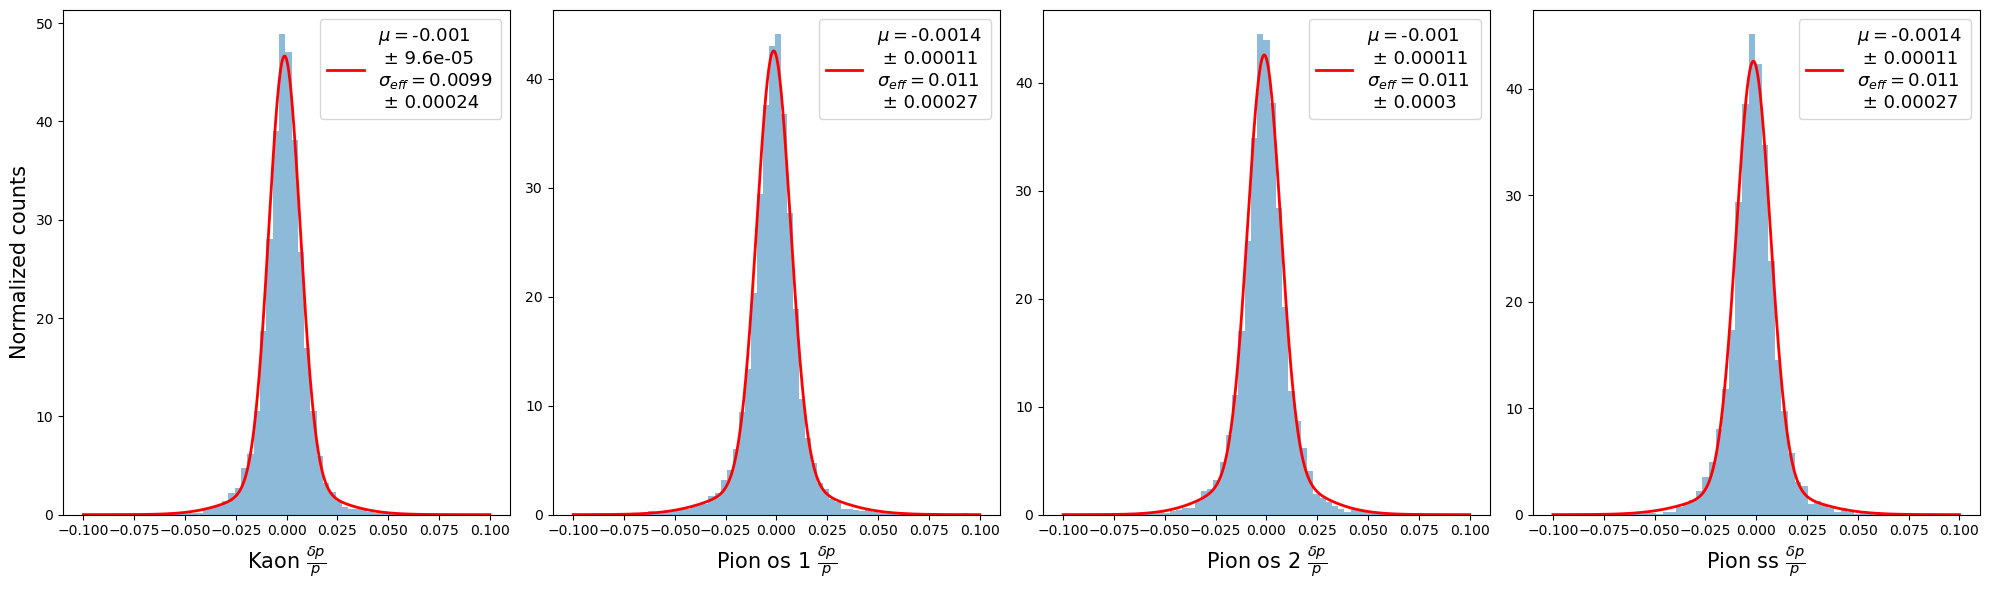

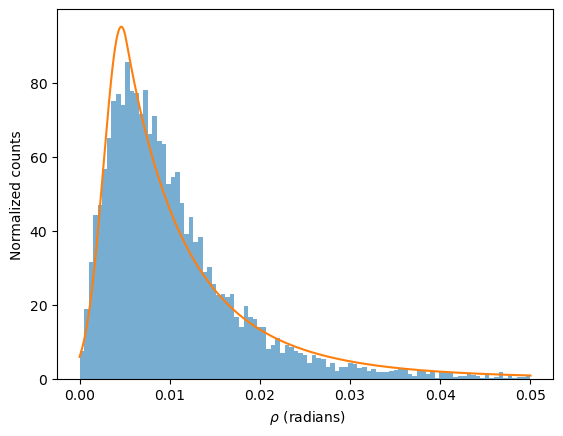

Currently at point 0 of 1.000.000


In [10]:
root = uproot.open(r'C:\Users\bnijm\Documents\Root\2018Down.root')
branch = root['Hlt2Dstp2D0Pip_D02KpPimPimPip_Tuple;1'] #kp is K+
twig = branch['DecayTree;1']

sig_evts_mev = sig_evts *1000

# In LabFrame
#smearing = Smearing(twig, sig_evts_mev, bounds = 0.04, type = "LabFrame")
#smearing.box_method_magnitude(number_of_points = 10000, factor = 2, sigma = 0.004*np.pi)

# Also possible to smear assuming momenta are uncorrelated, and thus smearing momenta along px, py, and pz instead of momentum magnitudes.
#smearing.box_method_individual_momenta(number_of_points = 5000, factor = 2)


# In D0 momentum frame
smearing = Smearing(twig, sig_evts_mev, bounds = 0.1, type = "D0Frame")
smearing.box_method_magnitude(number_of_points = 10000, factor = 1, sigma = 0)


# To store the smeared data in new pkl files that can be used in the k3pi-python fitter. The amplitudes need to be recalculated then
#smeared_sig_evts = np.array(smearing.smeared_sig_evts)
#sig_evts_new = smeared_sig_evts/1000
#with open(f'sig_evts.pkl', 'wb') as f:
#            pickle.dump(sig_evts_new, f)
#            pickle.dump(sig_t, f)
#            pickle.dump(sig_wgts, f)
#            pickle.dump(sig_dcs_amps, f)
#            pickle.dump(sig_cf_amps, f)


### **Making plot showing the resolution of the phase space variables of simulation and smeared data**

2017 Mag Up Wrong Sign
10791 11628


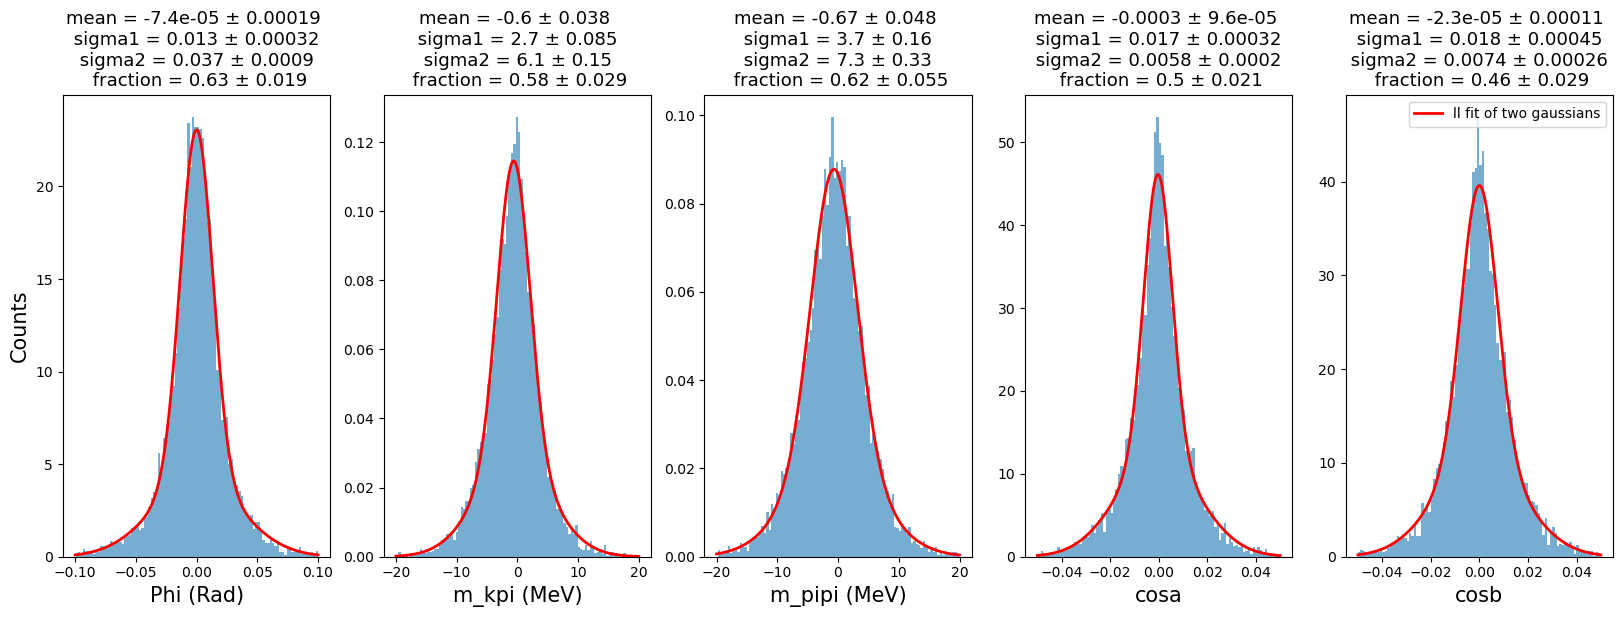

2017 Mag Down Wrong Sign
7507 8143


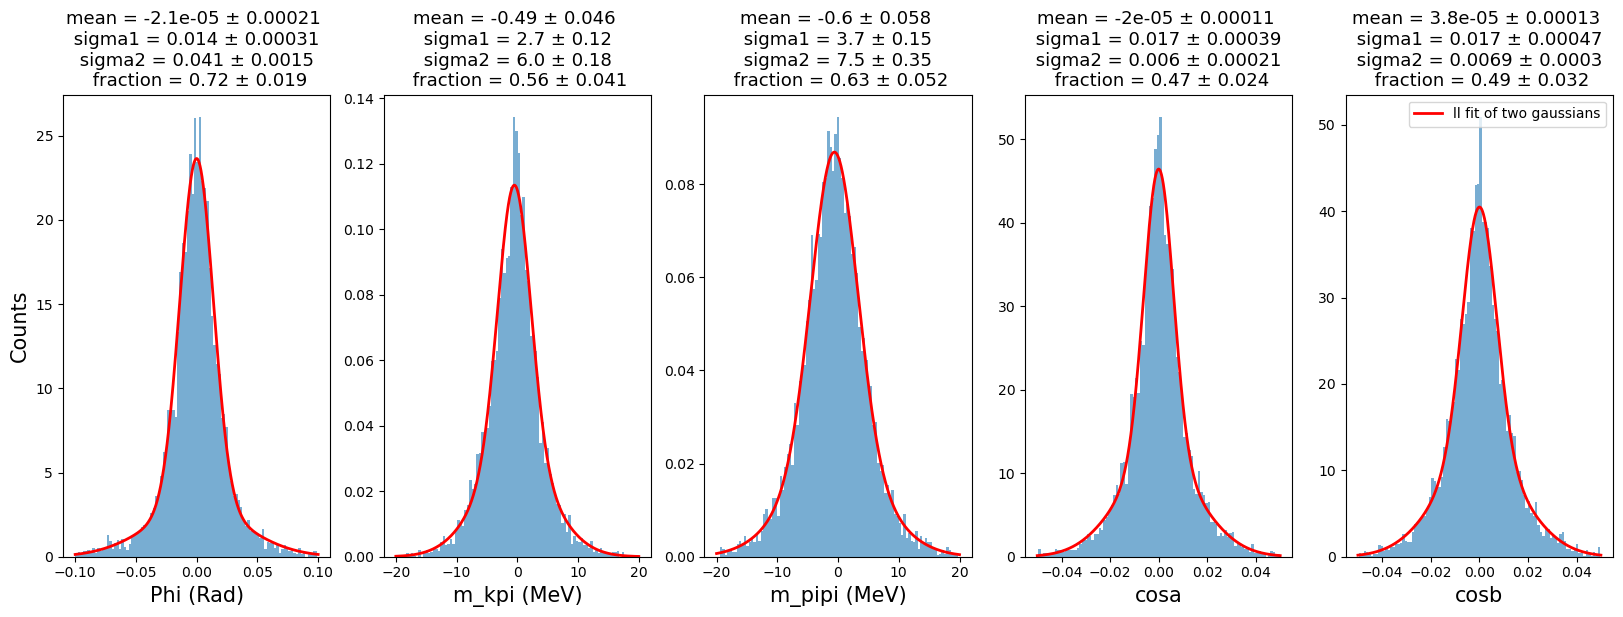

2018 Mag Up Wrong Sign
6402 6919


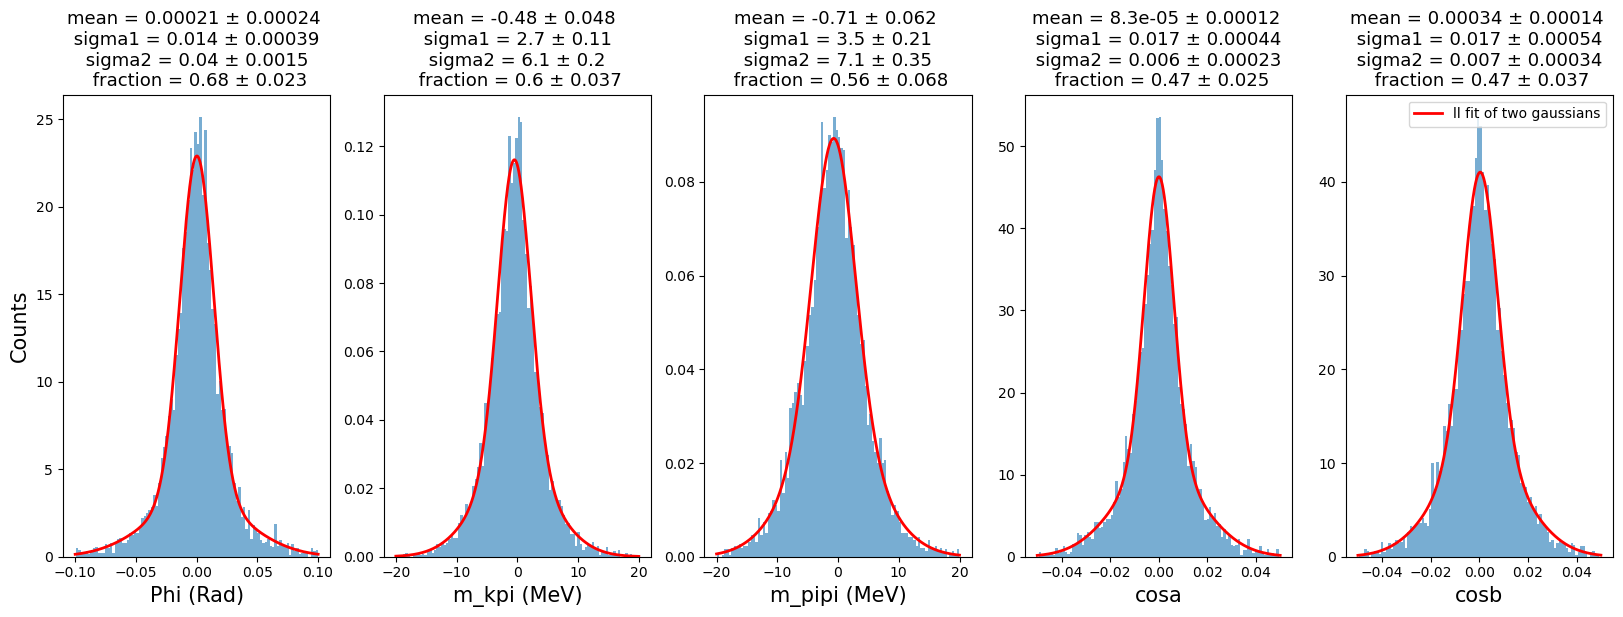

2018 Mag Down Wrong Sign
8592 9282


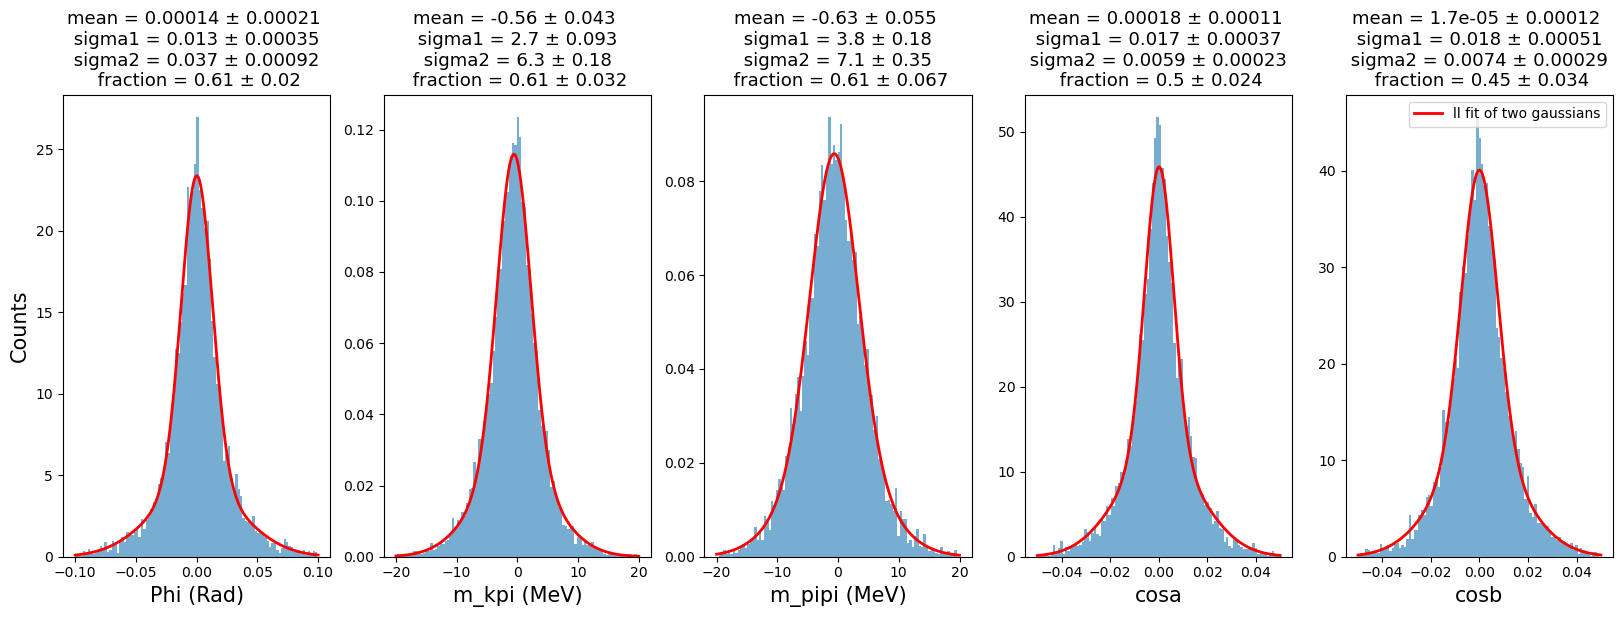

950246 1000000


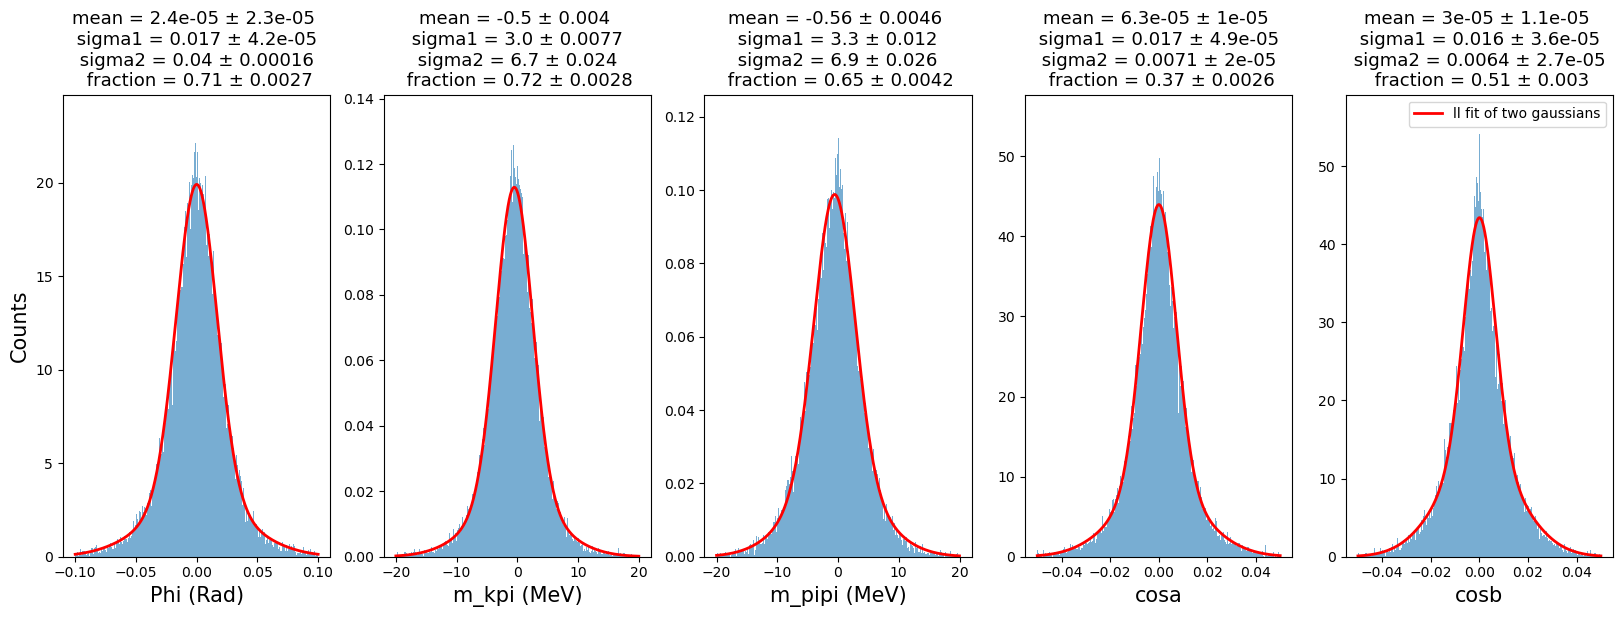

961673 1000000


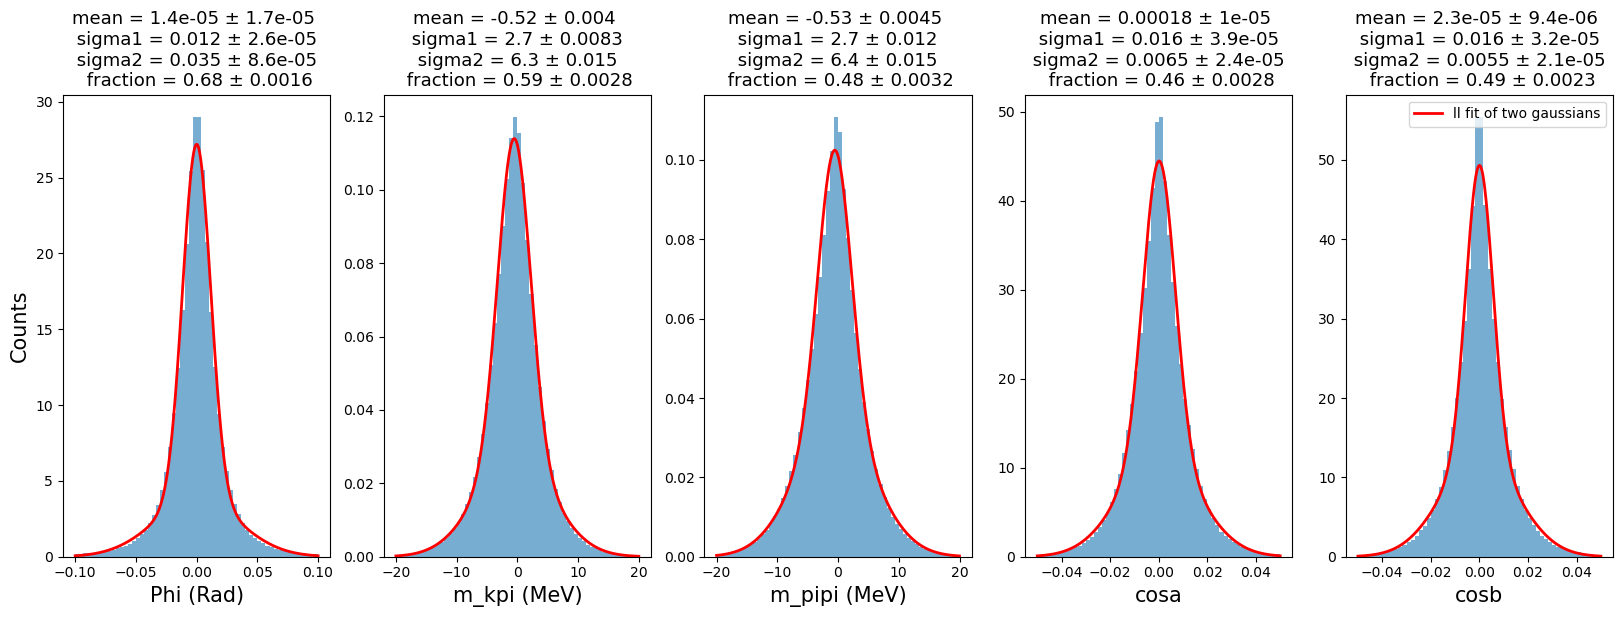

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, 

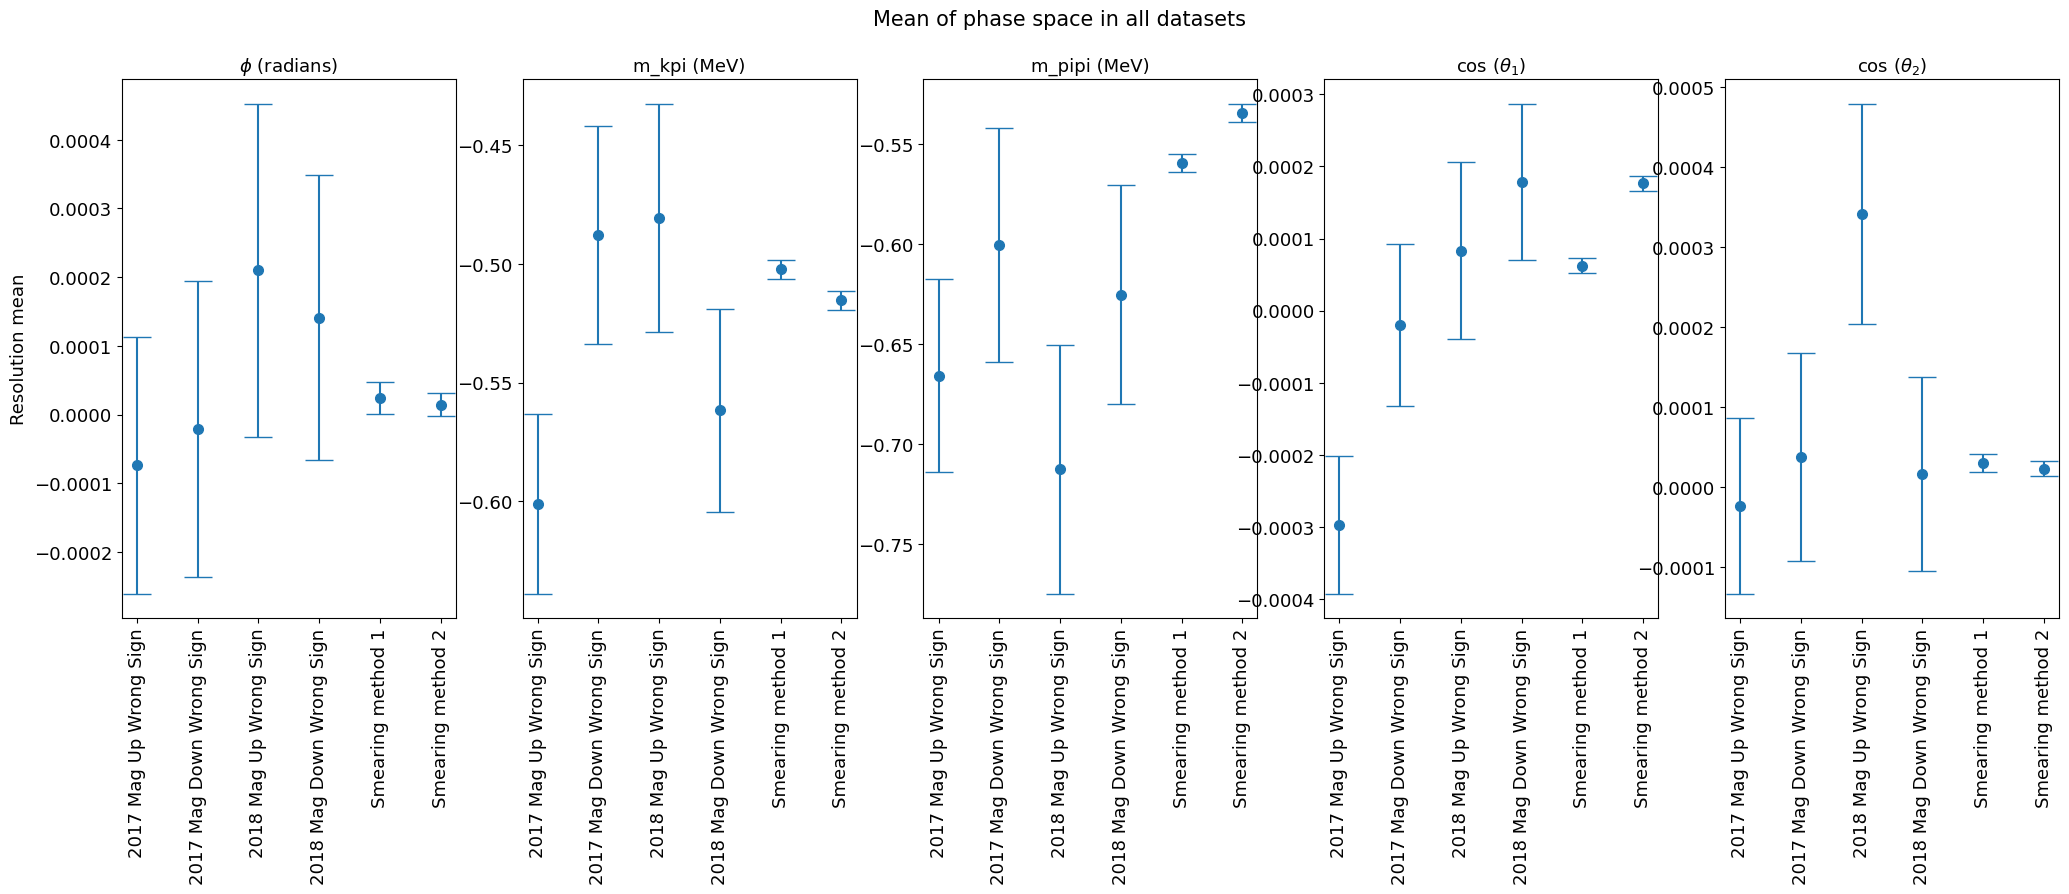

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3177596564.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(titles, 

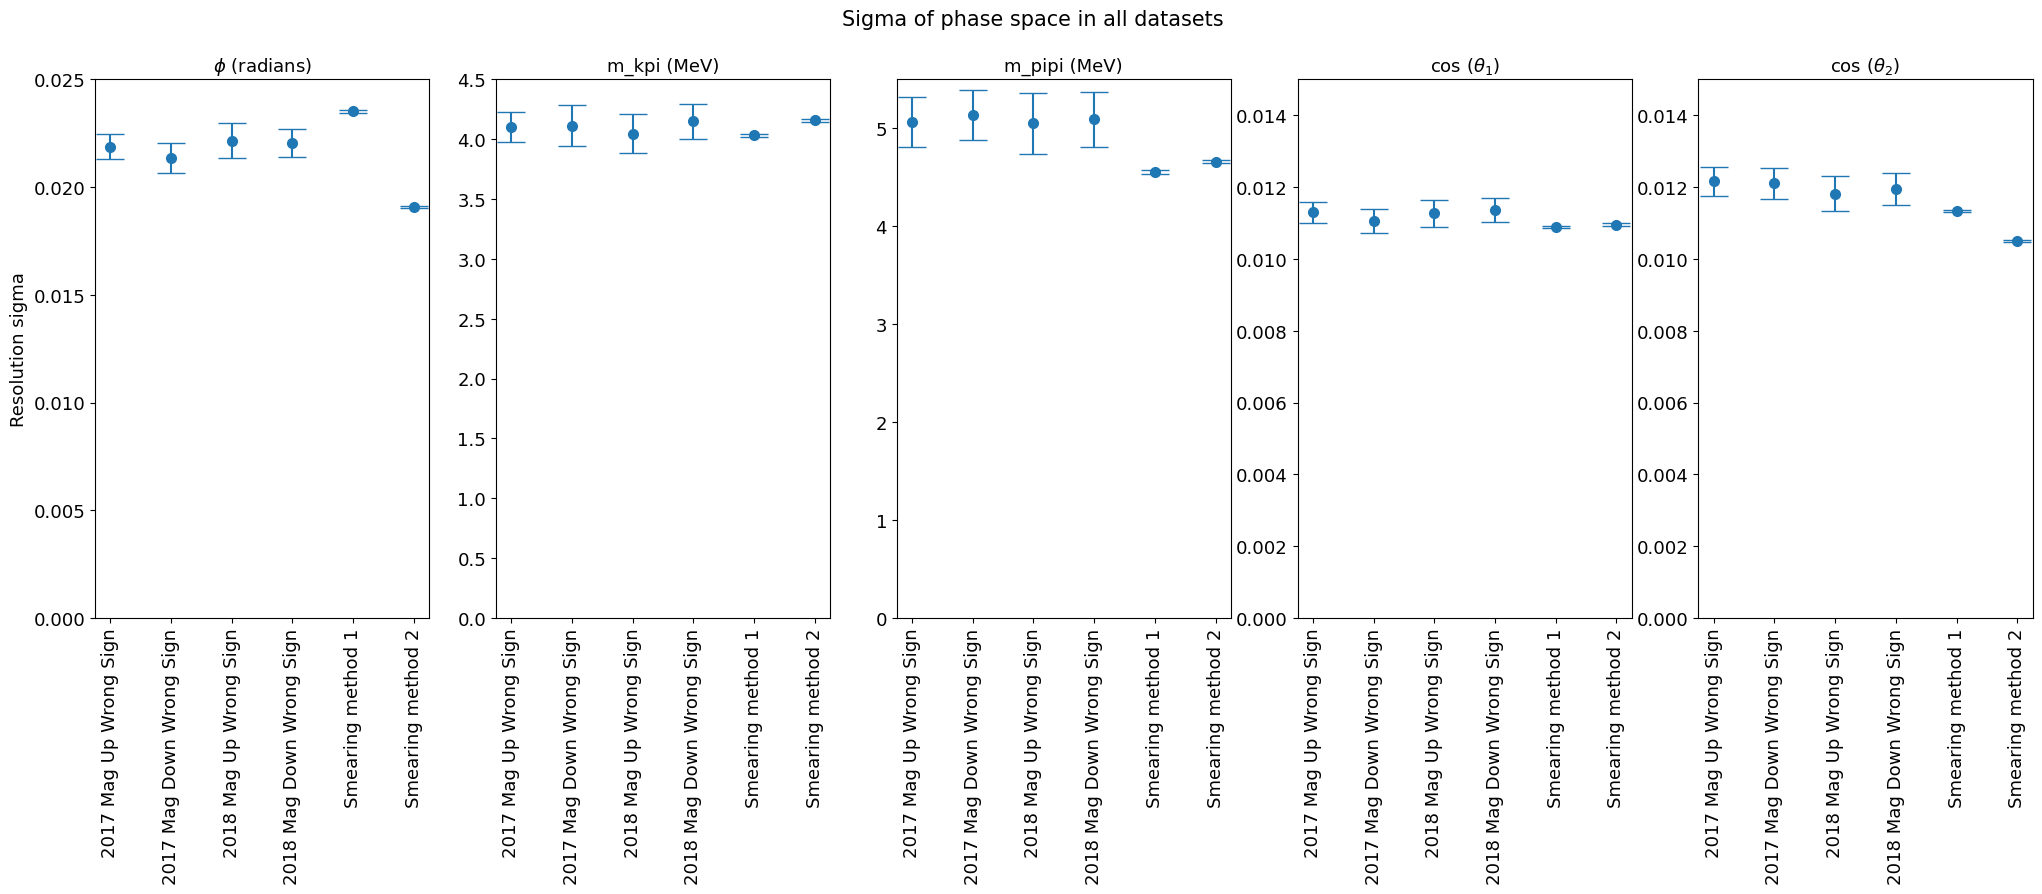

In [11]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

import pickle

path = r"C:\Users\bnijm\Documents\Root\\"
events = sig_evts * 1000
def fit_mean_sigma_phase_space(years=['2017','2018'],polarities=['Up','Down'],signs=['Wrong']):
    """
    Function that fits double gaussians to phase space variables of all simulation files and fully smeared AmpGen datasets and puts them in one plot.
    You could add "Right" sign decays to, or also add the 2016 files. However, in this thesis only wrong sign decays are considered and the 2016 file
    """
    means = []
    means_error = []
    sigmas = []
    sigmas_error = []
    titles = []
    for year in years:
        for polarity in polarities:
            for sign in signs:
                title = year +  ' Mag ' + polarity + ' ' + sign +' Sign'
                print(title)
                root = uproot.open(path + year + polarity +'.root')

                if sign == 'Right':
                    tree = root['Hlt2Dstp2D0Pip_D02KmPimPipPip_Tuple;1']
                if sign == 'Wrong':
                    tree = root['Hlt2Dstp2D0Pip_D02KpPimPimPip_Tuple;1']
                branch = tree['DecayTree;1']

                branch_c = Smearing(branch, events)
                
                rec_phase_space = branch_c.phase_space_variables("Reconstructed")
                true_phase_space = branch_c.phase_space_variables(True)

                n_bins = 80
                if sign == 'Right':
                    initial_values_1 = [0, 0.01, 0, 1, 0.6, 20]
                    initial_values_2 = [0, 2, 0, 5, 0.6, 3000]
                    initial_values_3 = [0, 2, 0, 6, 0.6, 3000]
                    initial_values_4 = [0, 0.001, 0, 0.5, 0.6, 20]
                    initial_values_5 = [0, 0.001, 0, 0.5, 0.6, 20]
                    initial_values = [initial_values_1, initial_values_2, initial_values_3, initial_values_4, initial_values_5]
                else:
                    initial_values_1 = [0, 0.01, 0.03, 0.6]
                    initial_values_2 = [0, 2, 5, 0.6]
                    initial_values_3 = [0, 2, 5, 0.6]
                    initial_values_4 = [0, 0.01, 0.003, 0.6]
                    initial_values_5 = [0, 0.01, 0.003, 0.6]

                    initial_values = [initial_values_1, initial_values_2, initial_values_3, initial_values_4, initial_values_5]

                    n_bins = 100
                    individual_smearing = phase_space_fitter(rec_phase_space, true_phase_space, [0.1, 20, 20, 0.05, 0.05] , initial_values, n_bins)
                    individual_smearing.plot_fits()   
                    mean, mean_err, sigma, sigma_err = individual_smearing.mean_average_sigma()
                
                means.append(mean)
                means_error.append(mean_err)
                sigmas.append(sigma)
                sigmas_error.append(sigma_err)

                titles.append(title)
    
    def load_sig(): # Load in original ampgen smeared events
        with open('sig_evts_non_smeared.pkl', 'rb') as f:
            sig_evts = pickle.load(f)
            sig_t = pickle.load(f)                                                                                                  
            sig_wgts = pickle.load(f)
            sig_dcs_amps = pickle.load(f)
            sig_cf_amps = pickle.load(f)
        return sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps

    sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps = load_sig()

    def load_sig(): # load in smeared AmpGen events using smearing method 1
        with open('sig_evts_smearing_method_1.pkl', 'rb') as f:
            sig_evts = pickle.load(f)
            sig_t = pickle.load(f)                                                                                                  
            sig_wgts = pickle.load(f)
            sig_dcs_amps = pickle.load(f)
            sig_cf_amps = pickle.load(f)
        return sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps
        
    sig_evts_s, sig_t_s, sig_wgts_s, sig_dcs_amps_s, sig_cf_amps_s = load_sig()
    sig_evts_s_mev = sig_evts_s * 1000
    title = "Smearing method 1"
    AmpGen = Smearing(branch, sig_evts_mev)
    smeared_AmpGen = Smearing(branch, sig_evts_s_mev)
    n_bins = 10000
    individual_smearing = phase_space_fitter(smeared_AmpGen.phase_space_variables("AmpGen"), AmpGen.phase_space_variables("AmpGen"), [0.1, 20, 20, 0.05, 0.05] , initial_values, n_bins)
    individual_smearing.plot_fits()
    mean, mean_err, sigma, sigma_err = individual_smearing.mean_average_sigma()

    means.append(mean)
    means_error.append(mean_err)
    sigmas.append(sigma)
    sigmas_error.append(sigma_err)

    titles.append(title)

    def load_sig(): # Load in smeared AmpGen data using smearing method 2
        with open('sig_evts_smearing_method_2.pkl', 'rb') as f:
            sig_evts = pickle.load(f)
            sig_t = pickle.load(f)                                                                                                  
            sig_wgts = pickle.load(f)
            sig_dcs_amps = pickle.load(f)
            sig_cf_amps = pickle.load(f)
        return sig_evts, sig_t, sig_wgts, sig_dcs_amps, sig_cf_amps
        
    sig_evts_s, sig_t_s, sig_wgts_s, sig_dcs_amps_s, sig_cf_amps_s = load_sig()
    sig_evts_s_mev = sig_evts_s * 1000
    
    title = "Smearing method 2"
    AmpGen = Smearing(branch, sig_evts_mev)
    smeared_AmpGen = Smearing(branch, sig_evts_s_mev)
    
    initial_values_1 = [0, 0.01, 0.03, 0.6]
    initial_values_2 = [0, 2, 5, 0.6]
    initial_values_3 = [0, 2, 5, 0.6]
    initial_values_4 = [0, 0.02, 0.006, 0.6]
    initial_values_5 = [0, 0.02, 0.006, 0.6]

    initial_values = [initial_values_1, initial_values_2, initial_values_3, initial_values_4, initial_values_5]
    n_bins = 60
    individual_smearing = phase_space_fitter(smeared_AmpGen.phase_space_variables("AmpGen"), AmpGen.phase_space_variables("AmpGen"), [0.1, 20, 20, 0.05, 0.05] , initial_values, n_bins)
    individual_smearing.plot_fits()
    mean, mean_err, sigma, sigma_err = individual_smearing.mean_average_sigma()

    means.append(mean)
    means_error.append(mean_err)
    sigmas.append(sigma)
    sigmas_error.append(sigma_err)

    titles.append(title)

    
    return np.array(means), np.array(means_error), np.array(sigmas), np.array(sigmas_error), titles


means, means_error, sigmas, sigmas_error, titles = fit_mean_sigma_phase_space()

fig, ax = plt.subplots(1,5, figsize  = (25,7))
names = [r"$\phi$ (radians)", "m_kpi (MeV)", "m_pipi (MeV)", r'cos ($\theta_1$)', r"cos ($\theta_2$)"]
limits = [[-0.0005,0.0005],[0,-0.8], [0,-0.8], [-0.0005,0.0005], [-0.0005,0.0005]]

for i in range(len(names)):
    
    ax[i].errorbar(titles, means[:,i], yerr = means_error[:,i], markersize = 7, capsize=10, ls = 'none', fmt = 'o')
    ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].set_title(names[i], fontsize = 13)


ax[0].set_ylabel("Resolution mean", fontsize = 13)
plt.suptitle(f"Mean of phase space in all datasets", fontsize = 15)
#fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,5, figsize  = (25,7))

limits = [[0,0.025],[0,4.5], [0,5.5], [0, 0.015], [0,0.015]]
for i in range(len(names)):
    
    ax[i].errorbar(titles, sigmas[:,i], yerr = sigmas_error[:,i], markersize = 7, capsize=10, ls = 'none', fmt = 'o')
    ax[i].set_xticklabels(titles, rotation=90, fontsize = 15)
    ax[i].set_ylim(limits[i])
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].set_title(names[i], fontsize = 13)


ax[0].set_ylabel("Resolution sigma", fontsize = 13)
plt.suptitle(f"Sigma of phase space in all datasets", fontsize = 15)
#fig.tight_layout()
plt.show()

### **Making plot showing the resolution of the relative magnitudes as the magnitude increases**

2017 Mag Up Wrong Sign
Number of points initially 1728, number of points after cut 1631


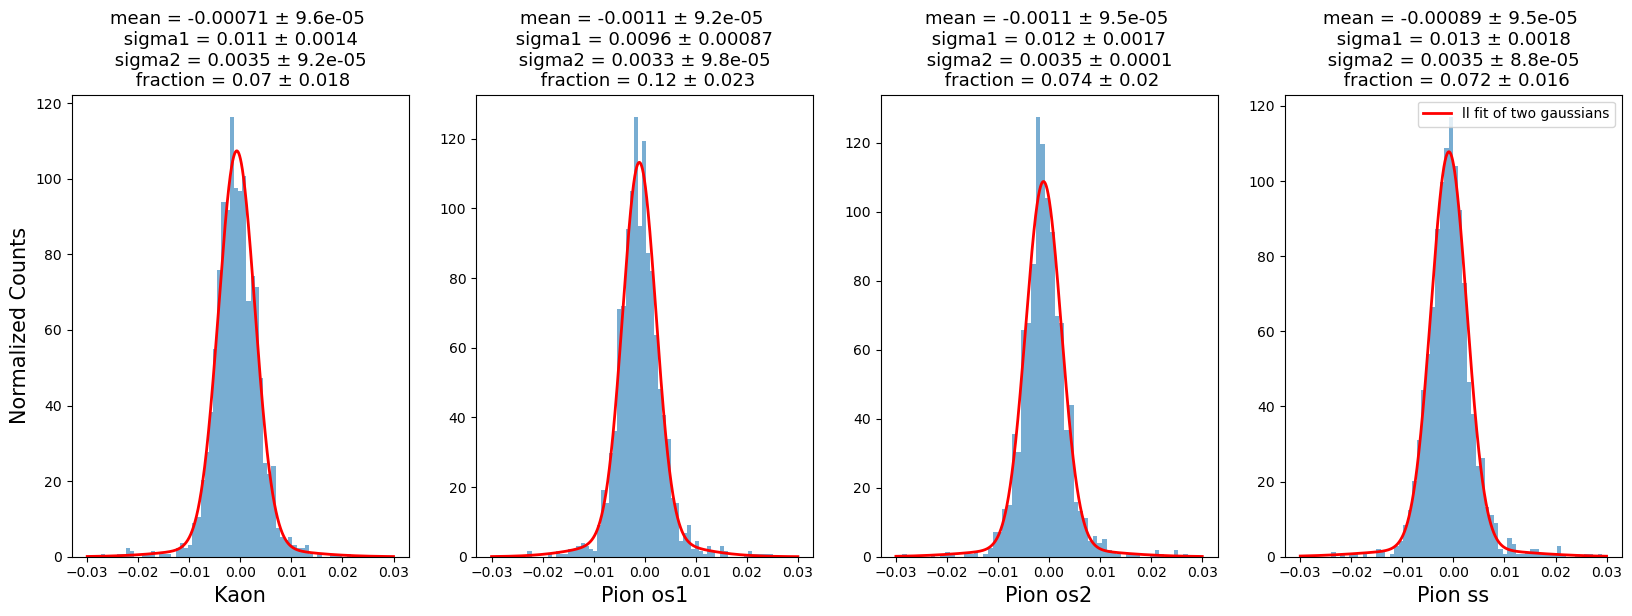

Number of points initially 1728, number of points after cut 1681


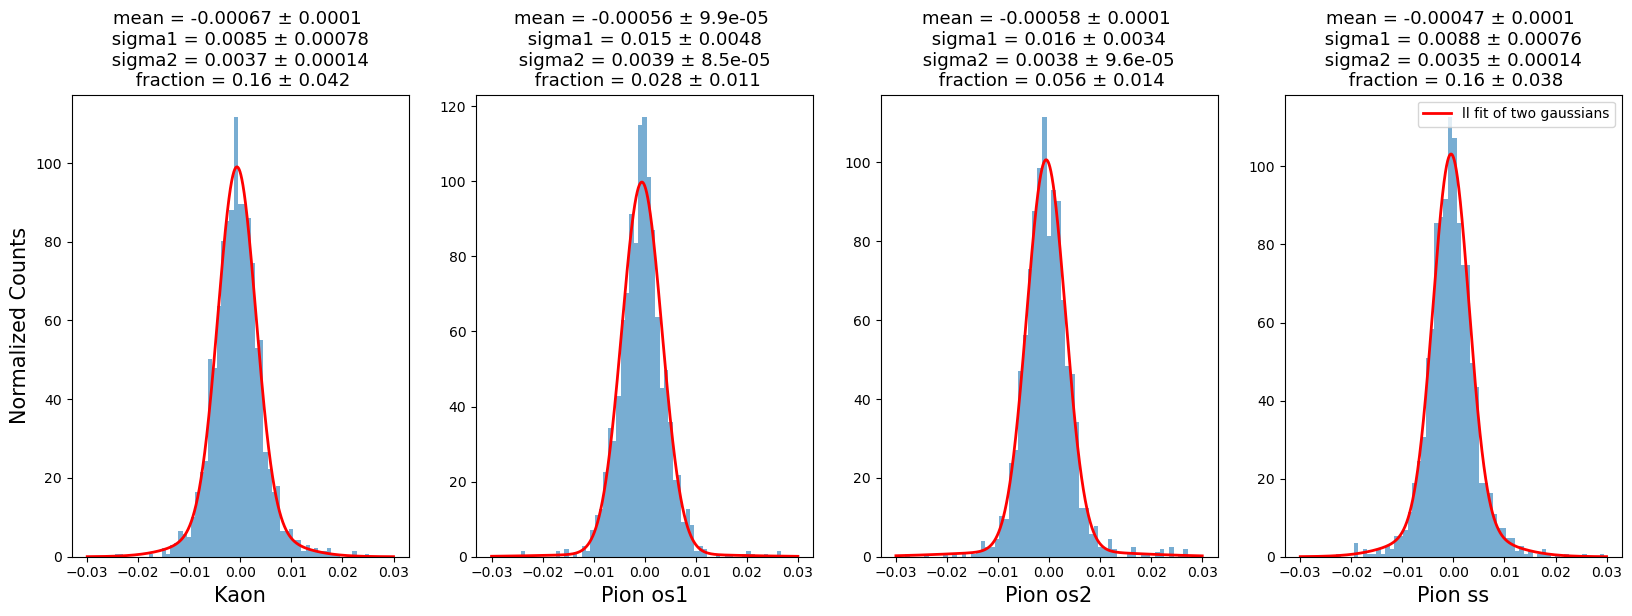

Number of points initially 1728, number of points after cut 1663


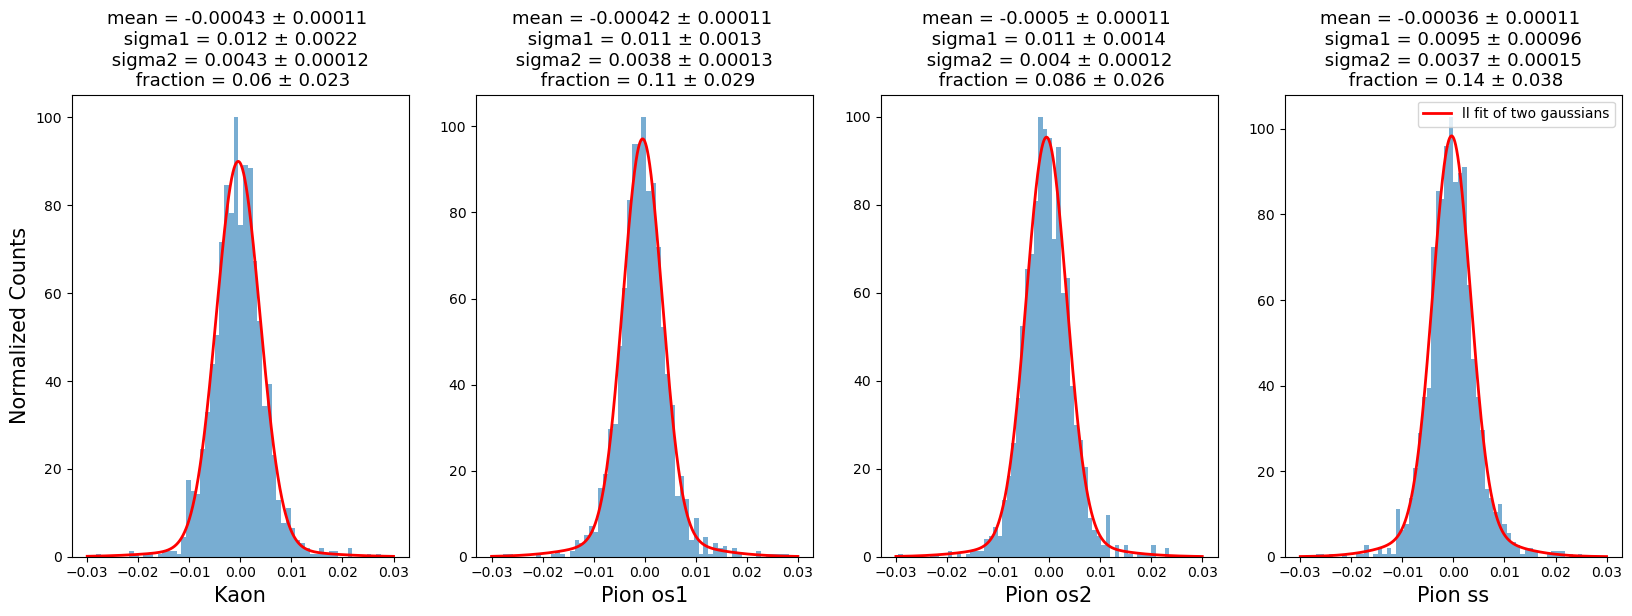

Number of points initially 1728, number of points after cut 1667


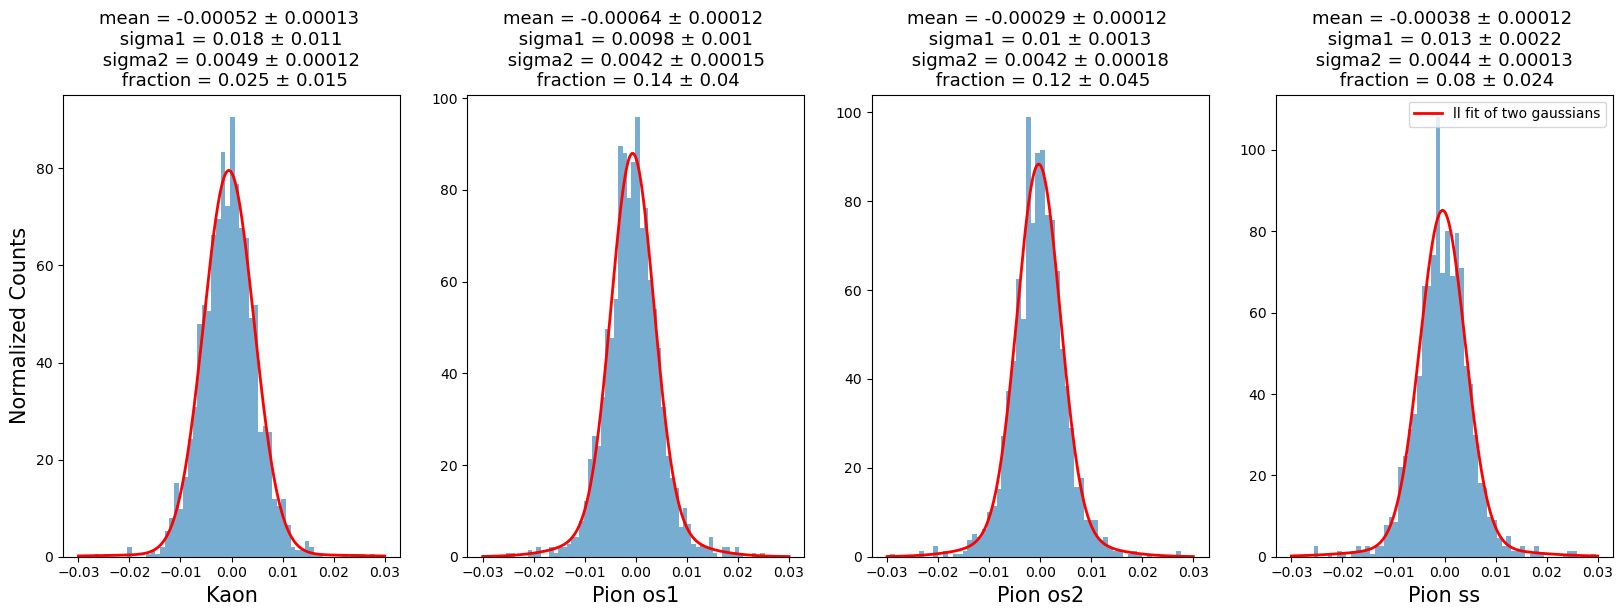

2017 Mag Down Wrong Sign
Number of points initially 1728, number of points after cut 1659


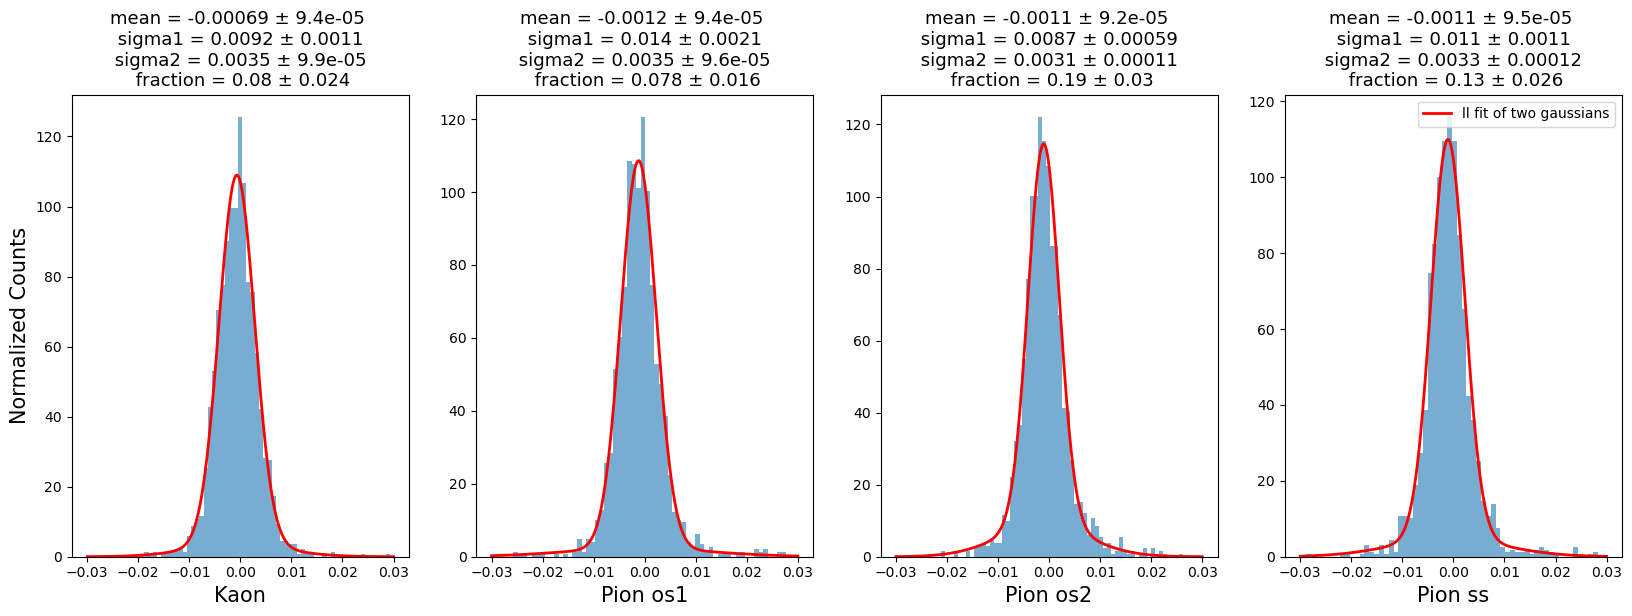

Number of points initially 1728, number of points after cut 1681


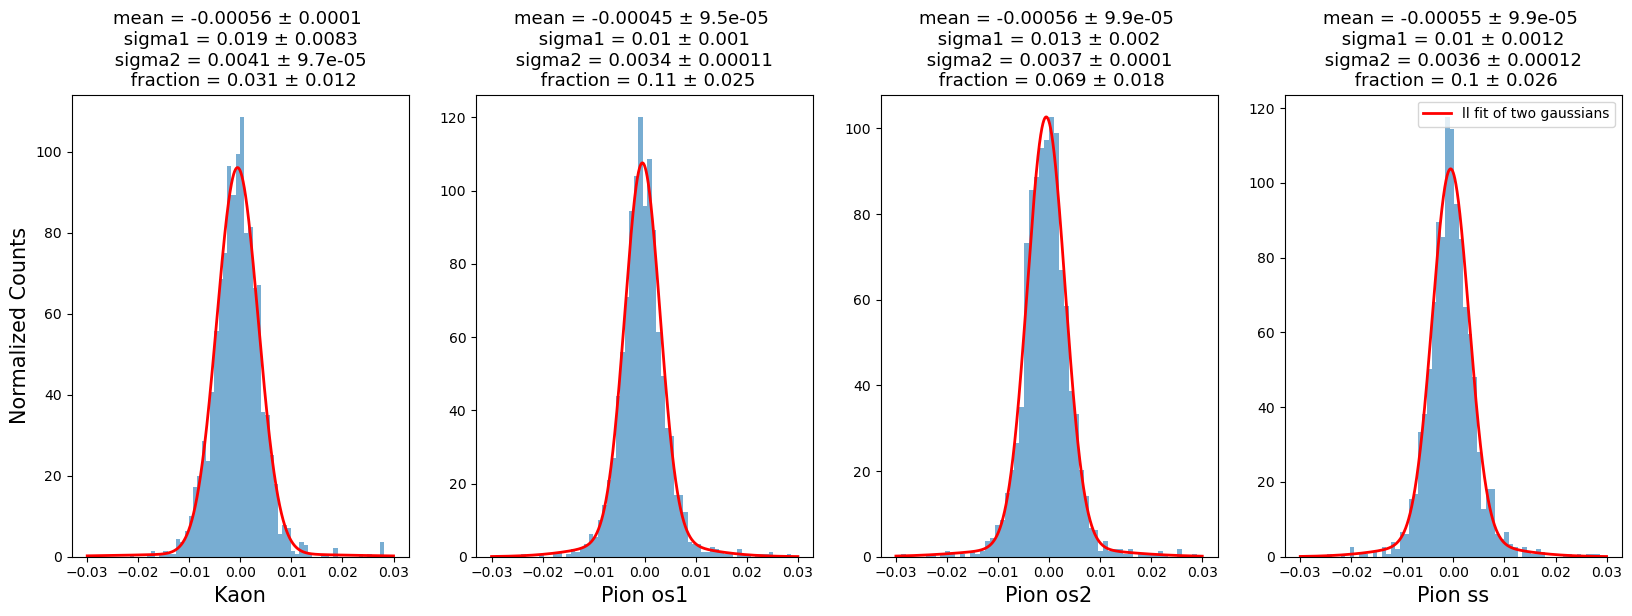

Number of points initially 1728, number of points after cut 1672


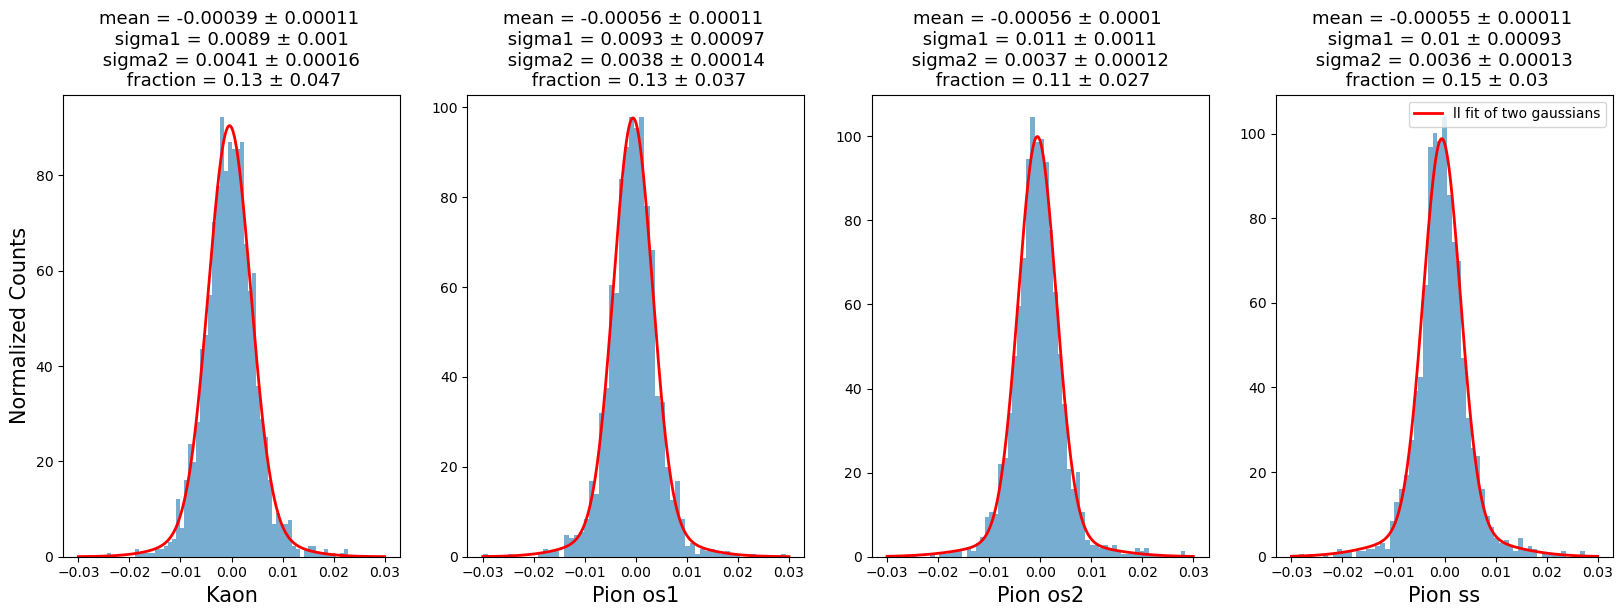

Number of points initially 1728, number of points after cut 1680


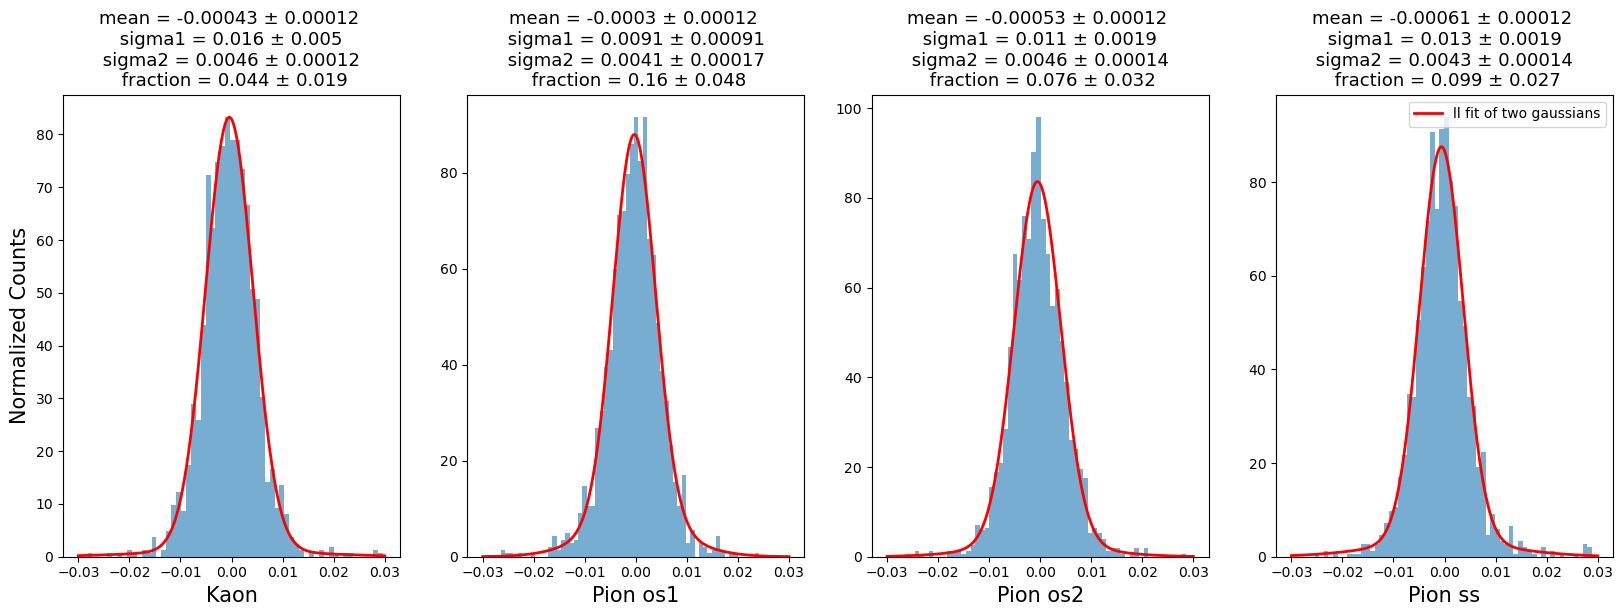

2018 Mag Up Wrong Sign
Number of points initially 1728, number of points after cut 1641


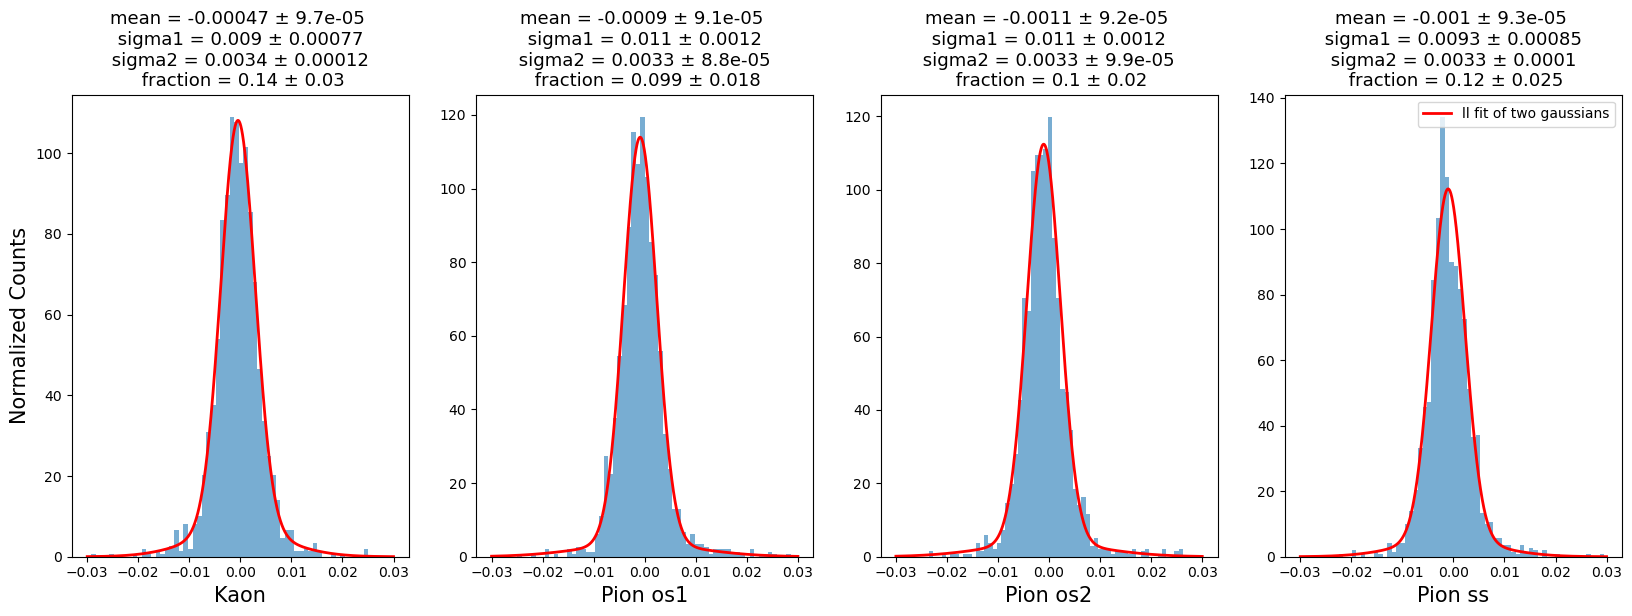

Number of points initially 1728, number of points after cut 1683


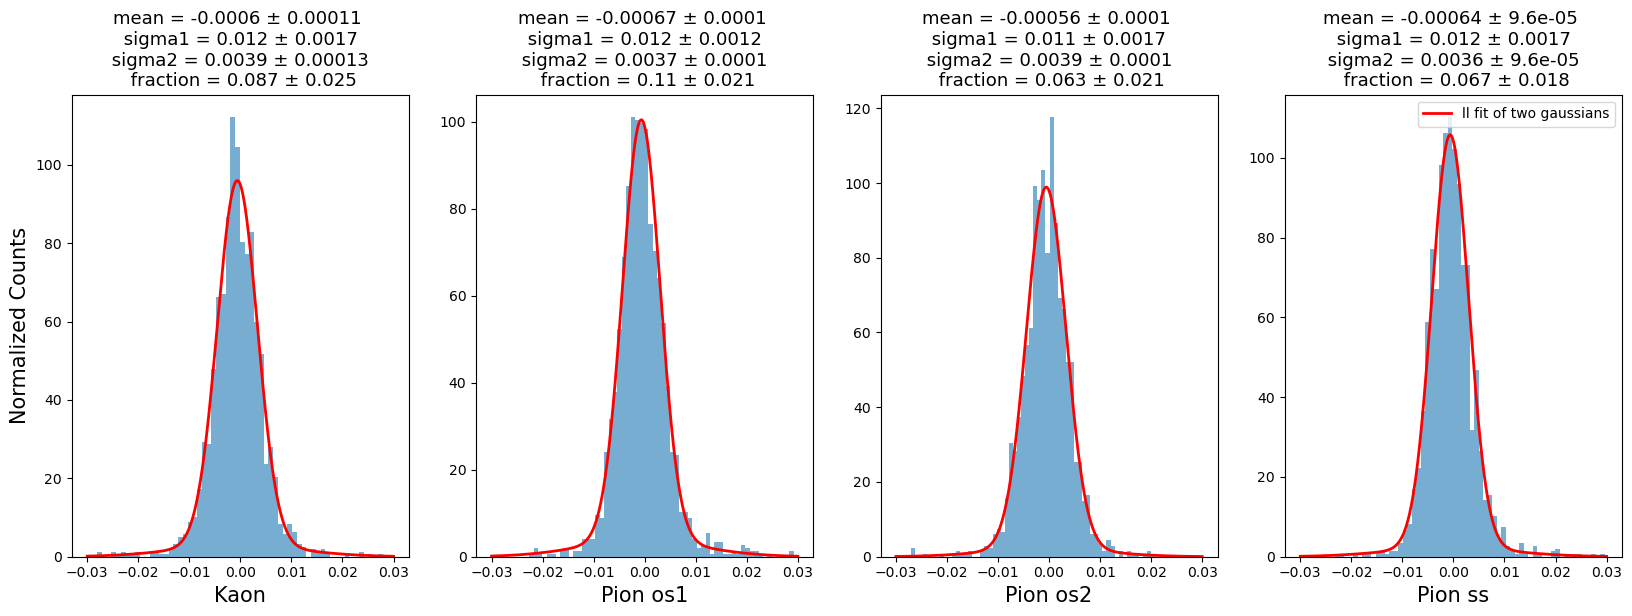

Number of points initially 1728, number of points after cut 1681


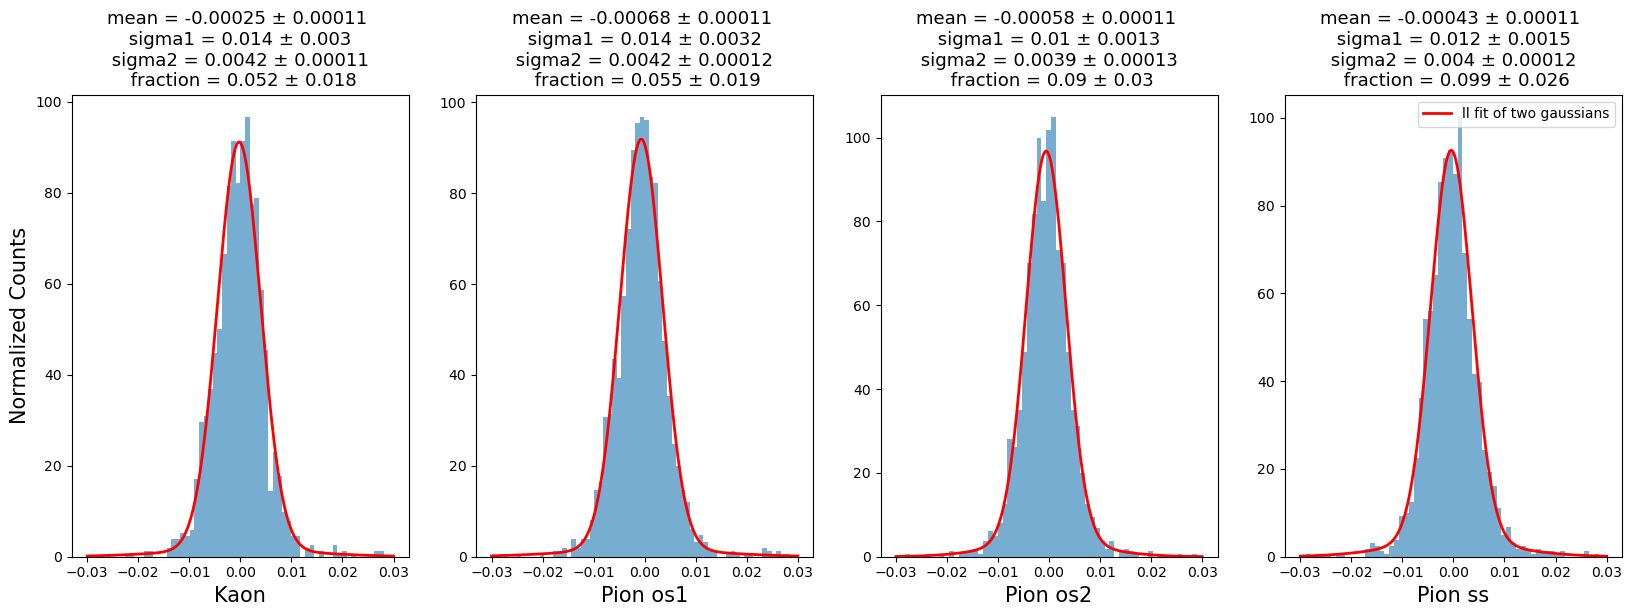

Number of points initially 1728, number of points after cut 1679


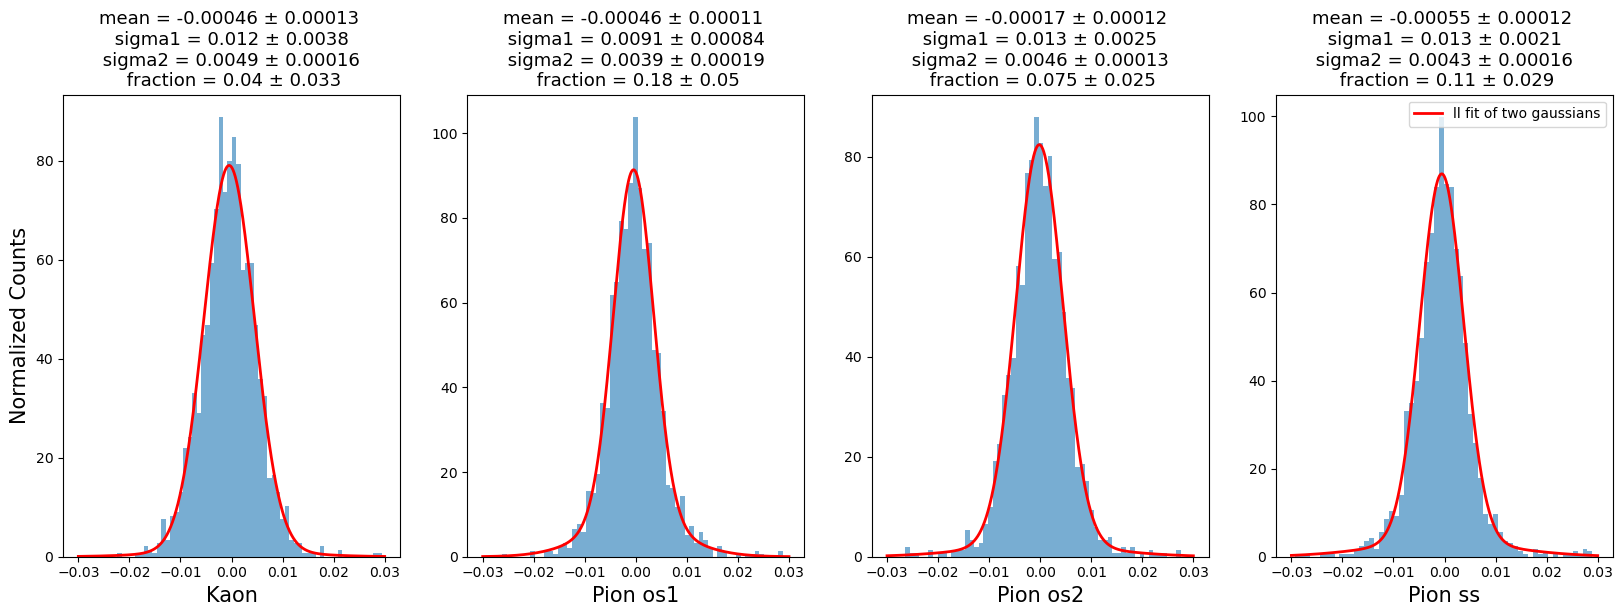

2018 Mag Down Wrong Sign
Number of points initially 1728, number of points after cut 1635


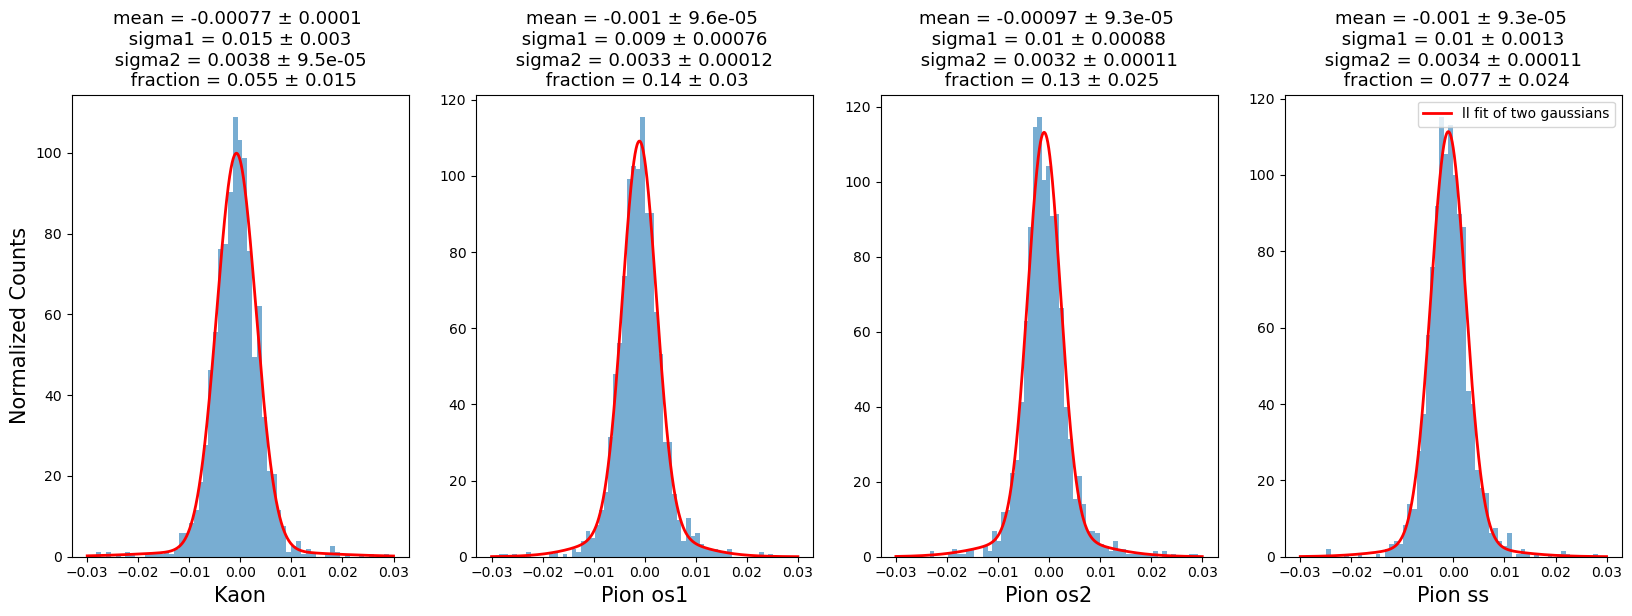

Number of points initially 1728, number of points after cut 1669


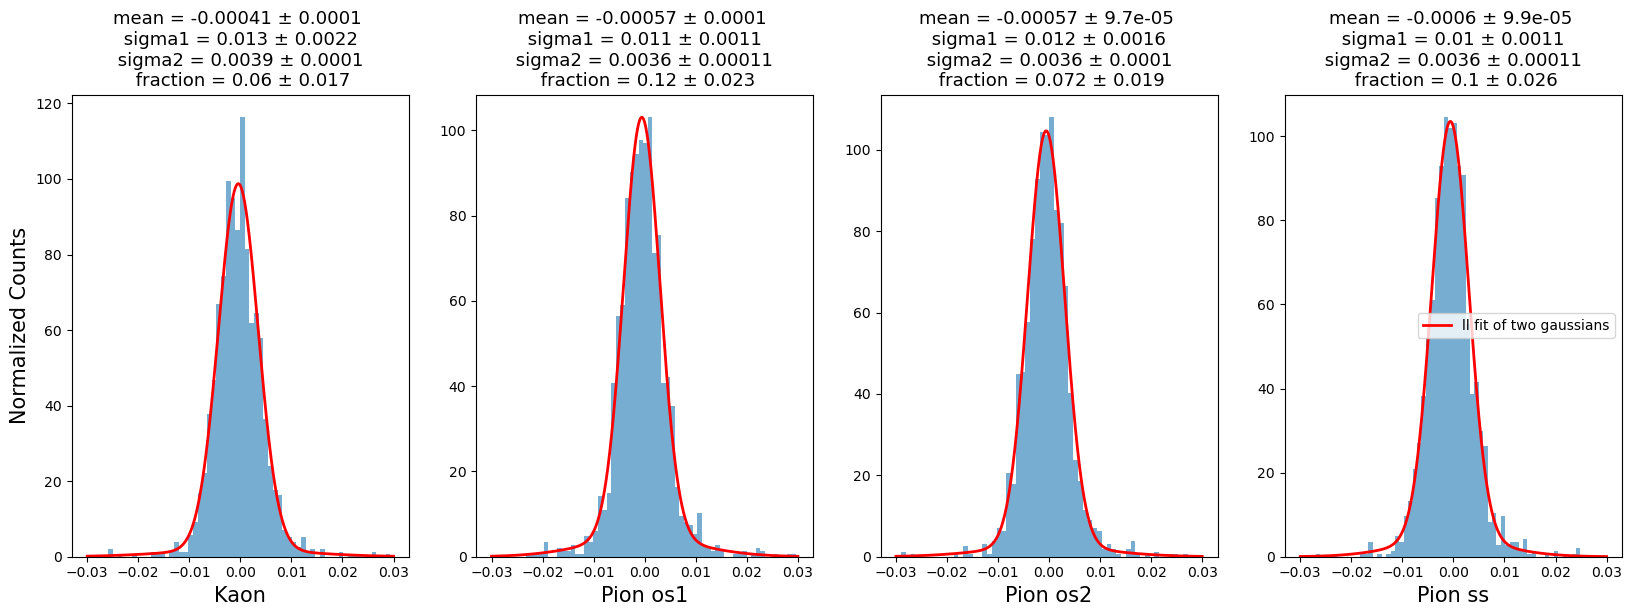

Number of points initially 1728, number of points after cut 1683


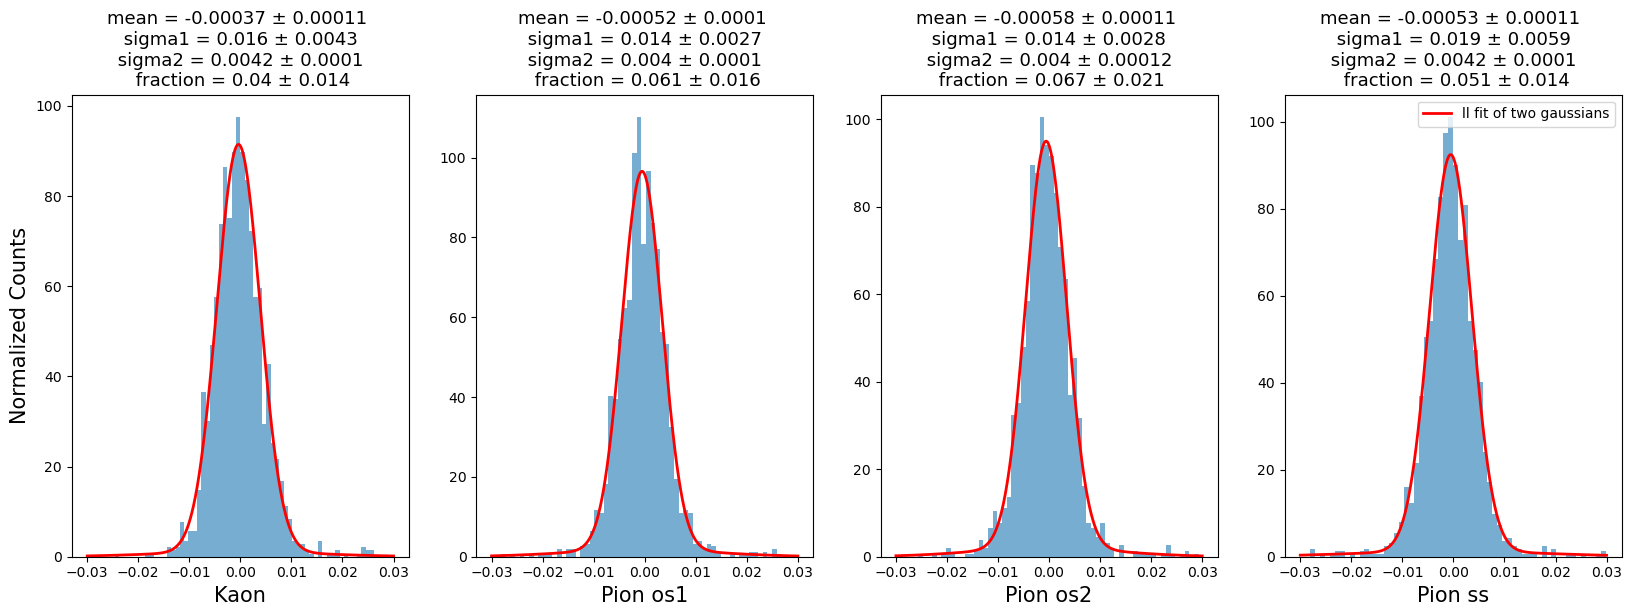

Number of points initially 1728, number of points after cut 1656


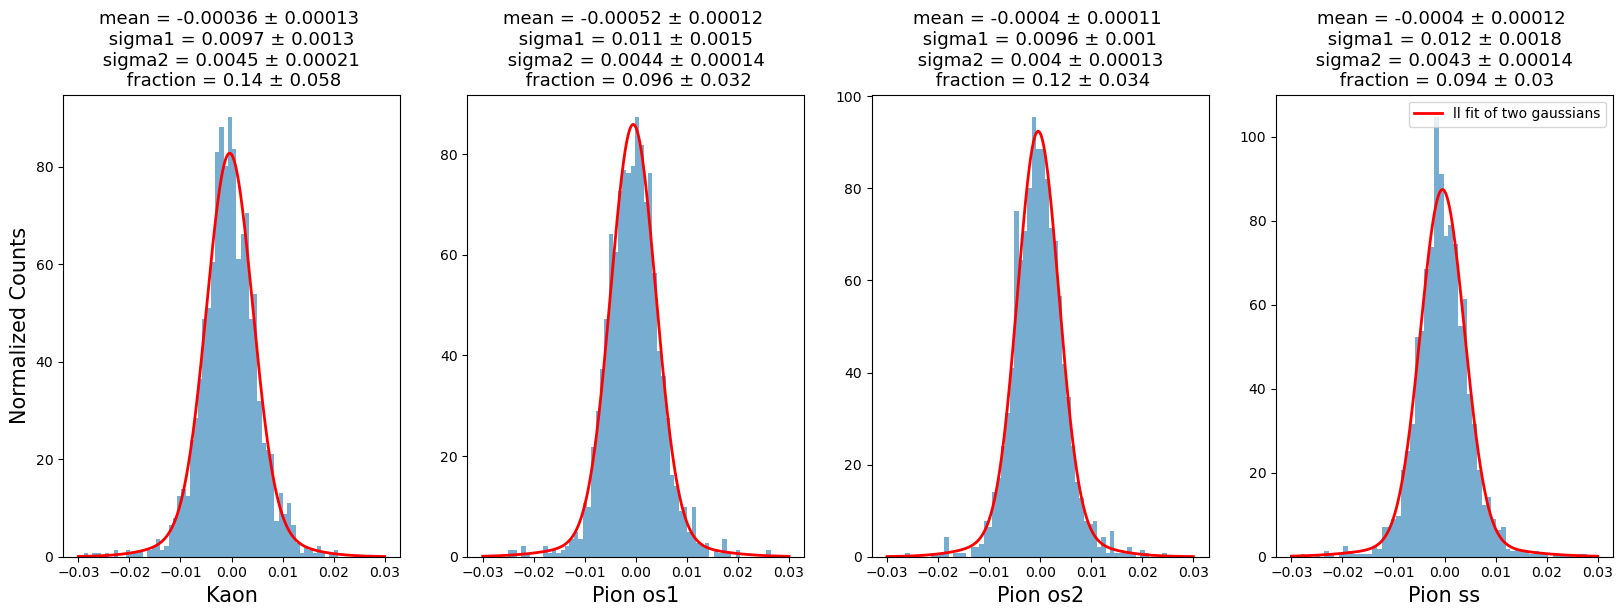

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)


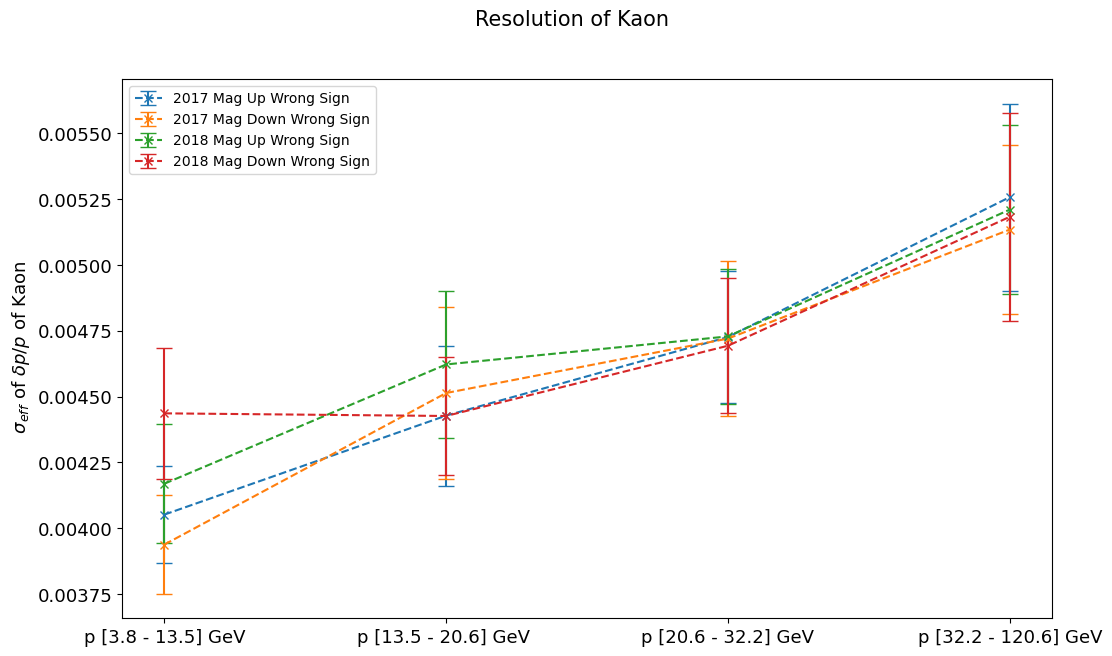

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)


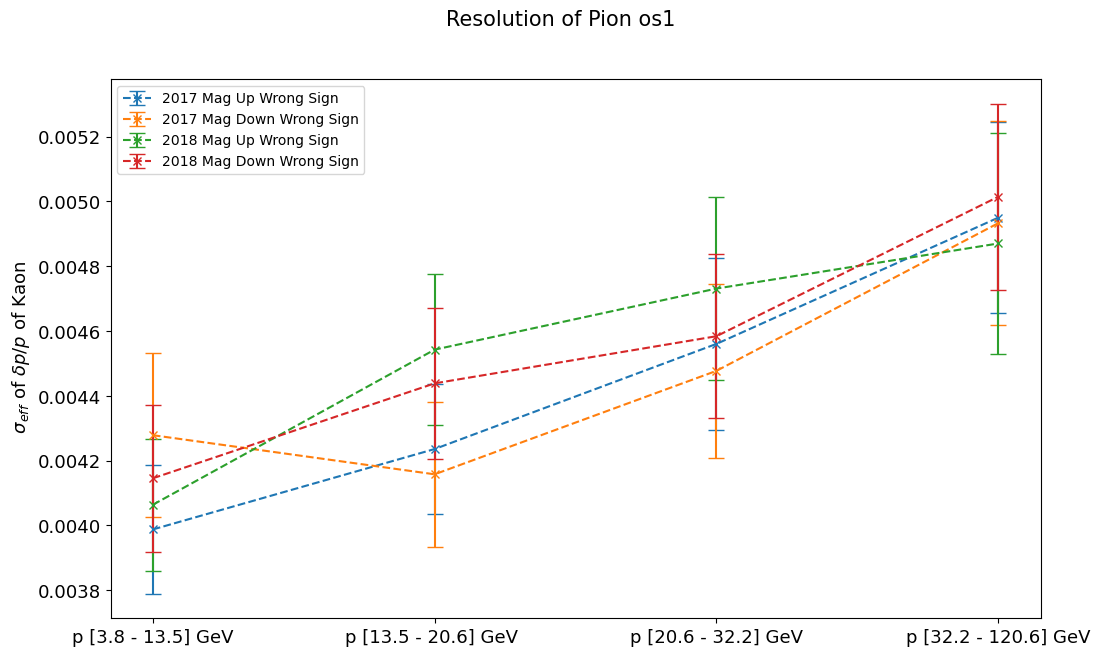

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)


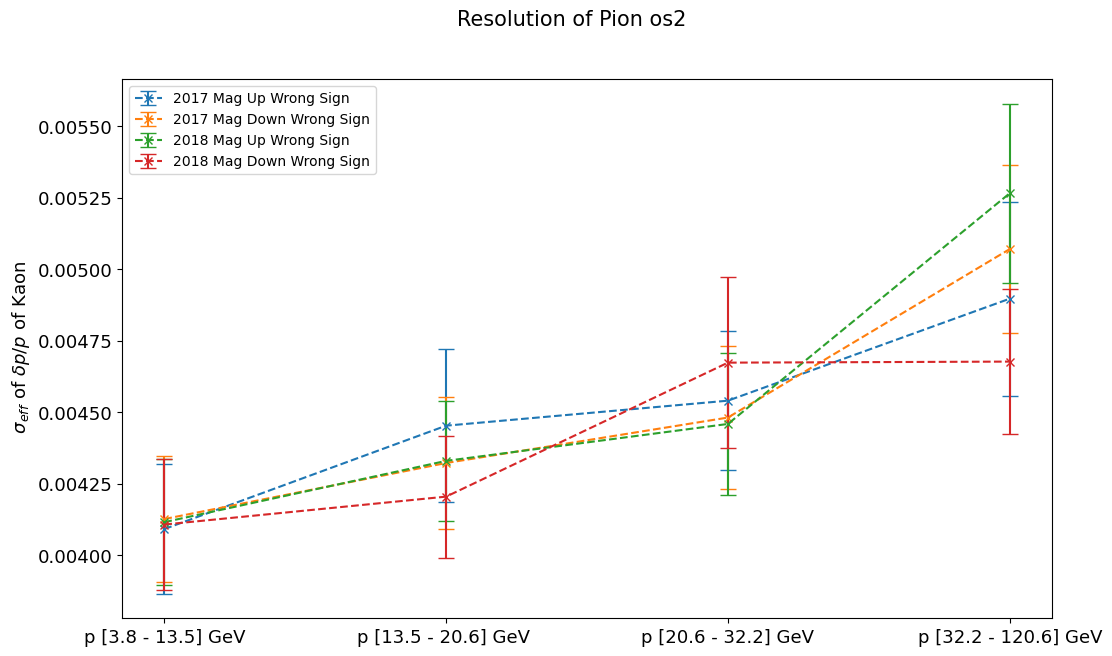

C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)
C:\Users\bnijm\AppData\Local\Temp\ipykernel_26844\3918926811.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_names,  fontsize = 15)


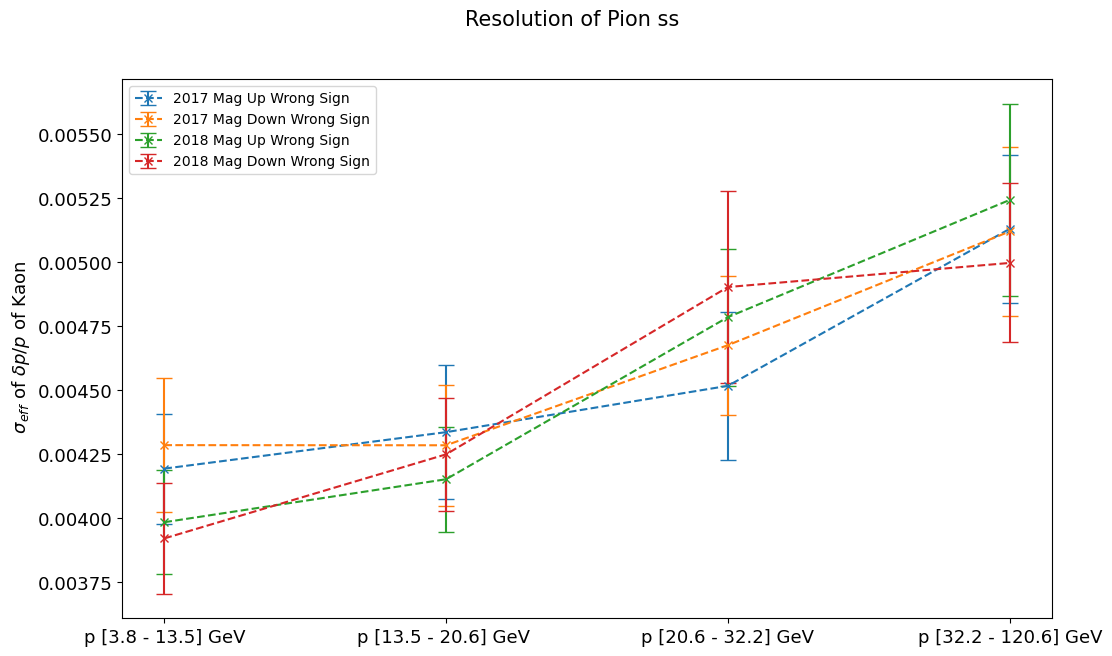

In [12]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

import pickle

path = r"C:\Users\bnijm\Documents\Root\\"
sig_events_mev = sig_evts * 1000
def fit_mean_sigma_split_momenta(years=['2017','2018'],polarities=['Up','Down'],signs=['Wrong']):
    means = []
    means_error = []
    sigmas = []
    sigmas_error = []
    bins = []
    titles = []
    for year in years:
        for polarity in polarities:
            for sign in signs:
                title = year +  ' Mag ' + polarity + ' ' + sign +' Sign'
                print(title)
                root = uproot.open(path + year + polarity +'.root')

                if sign == 'Right':
                    tree = root['Hlt2Dstp2D0Pip_D02KmPimPipPip_Tuple;1']
                if sign == 'Wrong':
                    tree = root['Hlt2Dstp2D0Pip_D02KpPimPimPip_Tuple;1']
                branch = tree['DecayTree;1']

                branch_c = Smearing(branch, sig_events_mev, type = "LabFrame", bounds = 0.2)

                [bins_p_k, bins_p_pi_os1, bins_p_pi_os2, bins_p_pi_ss], [dp_k, dp_pi_os1, dp_pi_os2, dp_pi_ss] = branch_c.momentum_magnitude_particles(type = "Split")
                
                bins.append([bins_p_k, bins_p_pi_os1, bins_p_pi_os2, bins_p_pi_ss])
                
                n_bins = 60
                initial_values = [0, 0.015, 0.003, 0.5] #for in lab frame
                #initial_values = [0, 0.02, 0.006, 0.3]
                for i in range(len(dp_k)):
                    # The [0:1728] is some bad coding, but need to be same length and because they are split in bins of not always same length
                    # In name of time this solution has to do
                    individual_smearing = phase_space_fitter([dp_k[i][0:1728], dp_pi_os1[i][0:1728], dp_pi_os2[i][0:1728], dp_pi_ss[i][0:1728]], 1, [0.03, 0.03, 0.03, 0.03] , initial_values, n_bins)
                    individual_smearing.plot_fits_split_momenta()   
                    mean, mean_err, sigma, sigma_err = individual_smearing.mean_average_sigma()
                
                    means.append(mean)
                    means_error.append(mean_err)
                    sigmas.append(sigma)
                    sigmas_error.append(sigma_err)

                titles.append(title)
    
    return np.array(means), np.array(means_error), np.array(sigmas), np.array(sigmas_error), titles, bins


means, means_error, sigmas, sigmas_error, titles, bins = fit_mean_sigma_split_momenta()


names = ["Kaon", "Pion os1", "Pion os2", "Pion ss"]
bin_names = ["p [3.8 - 13.5] GeV", "p [13.5 - 20.6] GeV ", "p [20.6 - 32.2] GeV", "p [32.2 - 120.6] GeV"] # This is approximation of the real bins
                                                                                                        # Holds true for the Kaon
for i in range(len(names)): #making plot for every particle
    
    fig, ax = plt.subplots(1,1, figsize  = (12,7))
    sigma_particle = sigmas[:,i]
    sigma_err_particle = sigmas_error[:,i]
    for j in range(4):
        
        ax.errorbar(titles, sigma_particle[4*j:4*j+4], yerr = sigma_err_particle[4*j:4*j+4], label = titles[j], markersize = 6, capsize=6, ls = '--', fmt = 'x')
        ax.set_xticklabels(bin_names,  fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.set_ylabel(r" $\sigma_{eff}$ of $\delta p /p$ of Kaon ", fontsize = 13)
        ax.legend()


    
    plt.suptitle(f"Resolution of " + names[i], fontsize = 15)
    #fig.tight_layout()
    plt.show()



### **Checking for correlation**

In [17]:
root = uproot.open(r'C:\Users\bnijm\Documents\Root\2018Down.root')
root.keys() #the names of all of the branches of the root file
branch = root['Hlt2Dstp2D0Pip_D02KpPimPimPip_Tuple;1'] #kp is K+
twig = branch['DecayTree;1']

sig_evts_mev = sig_evts *1000
smearing = Smearing(twig, sig_evts_mev)
relative_individual_momenta = smearing.individual_momenta_data()

Number of points initially 9282, number of points after cut 8734
Number of points initially 9282, number of points after cut 8548
Number of points initially 9282, number of points after cut 8535
Number of points initially 9282, number of points after cut 8499


C:\Users\bnijm\AppData\Local\Temp\ipykernel_15600\3480944278.py:229: RuntimeWarning: divide by zero encountered in divide
  relative_diff_true_rec_all = diff_true_rec_p/true_p


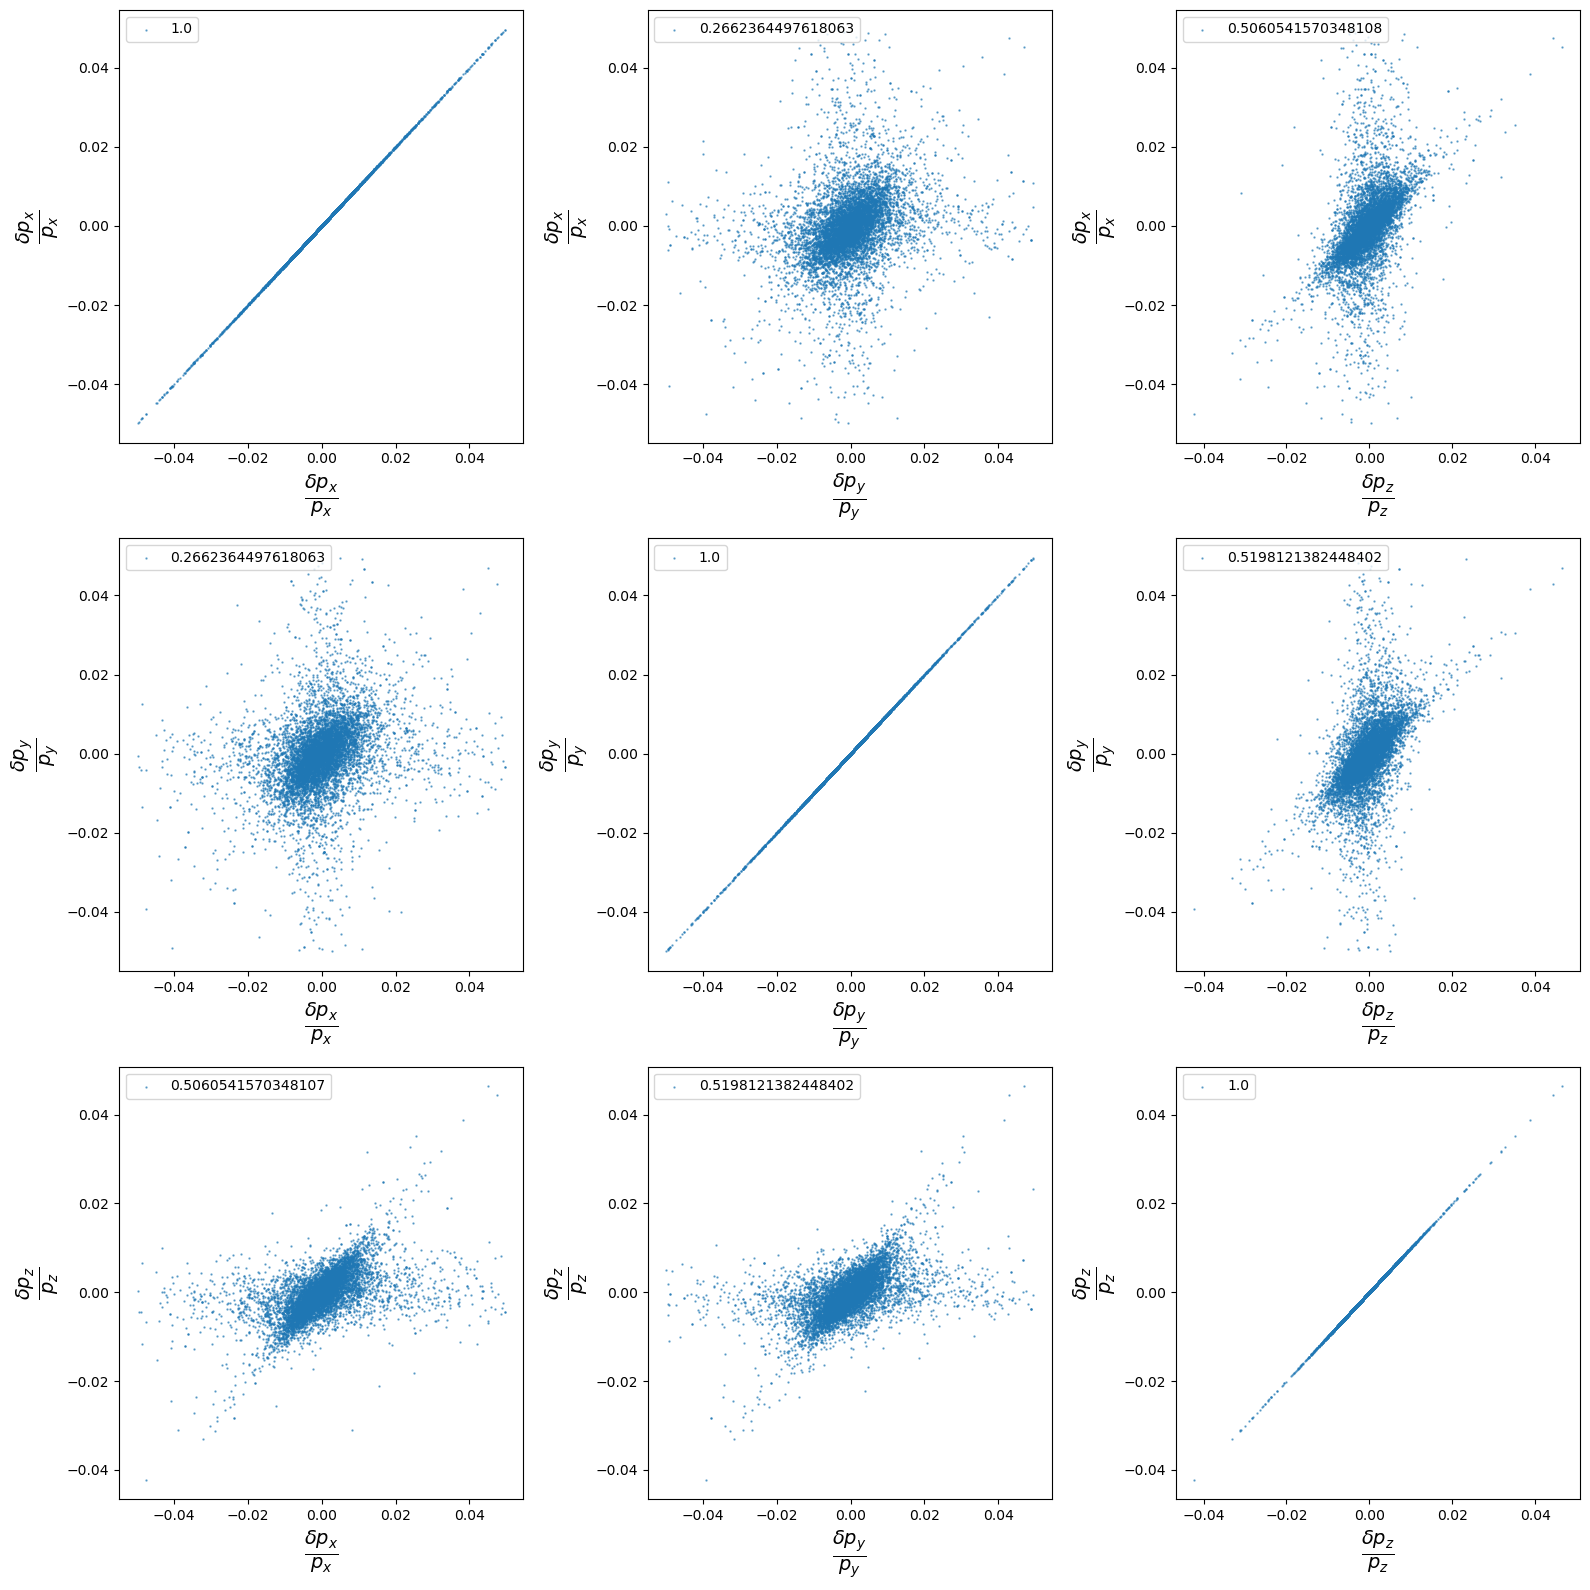

In [27]:

names = ["PE", r"$\frac{\delta p_x}{p_x}$", r"$\frac{\delta p_y}{p_y}$", r"$\frac{\delta p_z}{p_z}$"]

fig, ax = plt.subplots(3,3, figsize  = (16,16))
corr = np.corrcoef(relative_individual_momenta[0][1:4])

for j in range(3):
    for i in range(3):
        ax[j,i].scatter(relative_individual_momenta[0][i+1], relative_individual_momenta[0][j+1], label = f"{corr[i,j]}", alpha = 0.6, s = 0.5)
        ax[j,i].set_xlabel(names[i+1], fontsize = 20)
        ax[j,i].set_ylabel(names[j+1], fontsize = 20)
        ax[j,i].legend(loc = "upper left")

plt.suptitle("Kaon relative momenta")
fig.tight_layout()
plt.show()

In [19]:
np.corrcoef(relative_individual_momenta[0][1:4])

array([[1.        , 0.26623645, 0.50605416],
       [0.26623645, 1.        , 0.51981214],
       [0.50605416, 0.51981214, 1.        ]])

### **Comparison of momenta simulation and AmpGen**

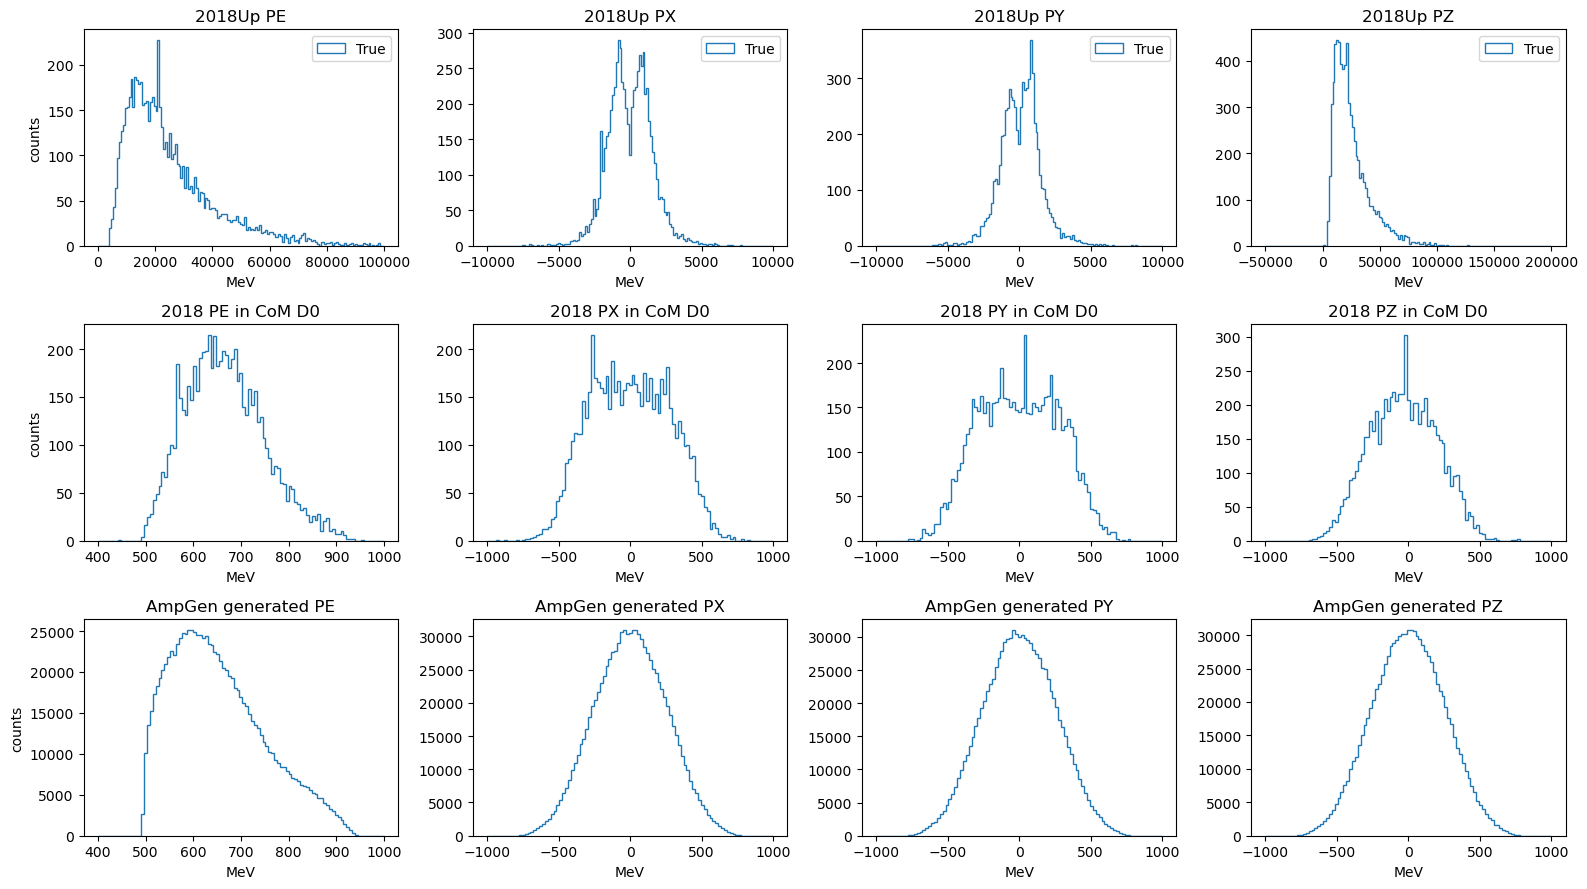

In [13]:
Momentum_names = ["PE","PX", "PY", "PZ"]

root = uproot.open(r'C:\Users\bnijm\Documents\Root\2018Up.root')
root.keys() #the names of all of the branches of the root file
branch = root['Hlt2Dstp2D0Pip_D02KpPimPimPip_Tuple;1'] #kp is K+
twig = branch['DecayTree;1']
twig.keys()
Bkg_Cat = uproot.models.TBranch.Model_TBranch_v12.array(twig['D0_BKGCAT']) 

D0_PX_t = uproot.models.TBranch.Model_TBranch_v12.array(twig['D0_P0_TRUEP_X'])
D0_PY_t = uproot.models.TBranch.Model_TBranch_v12.array(twig['D0_P0_TRUEP_Y'])
D0_PZ_t = uproot.models.TBranch.Model_TBranch_v12.array(twig['D0_P0_TRUEP_Z'])
D0_PE_t = uproot.models.TBranch.Model_TBranch_v12.array(twig['D0_P0_P'])

True_p = [D0_PE_t, D0_PX_t, D0_PY_t, D0_PZ_t]

sig_evts_mev = sig_evts *1000
smearing = Smearing(twig, sig_evts_mev)

p_k, p_pi_os1, p_pi_os2, p_pi_ss = smearing.truth_matching(smearing.true_four_vector())
p_d0 = p_k + p_pi_os1 + p_pi_os2 + p_pi_ss
p_k = p_k.boostCM_of(p_d0)
p_pi_ss = p_pi_ss.boostCM_of(p_d0)
p_pi_os1 = p_pi_os1.boostCM_of(p_d0)
p_pi_os2 = p_pi_os2.boostCM_of(p_d0)


bins = [np.linspace(0, 0.1*10**6, 150), np.linspace(-10000, 10000, 150), np.linspace(-10000, 10000, 150), np.linspace(-0.05*10**6, 0.2*10**6, 150)]
bins_com = [np.linspace(400, 1000, 100), np.linspace(-1000, 1000, 100), np.linspace(-1000, 1000, 100), np.linspace(-1000, 1000, 100)]


fig, ax = plt.subplots(3,4, figsize  = (16,9))

ax = ax.flatten()

ax[8].hist(sig_evts[:,3] *1000, bins = bins_com[0], histtype = 'step')
for i in range(3):
    ax[i+9].hist(sig_evts[:,i] *1000, bins = bins_com[i+1], histtype = 'step')

for i in range(4):
    ax[i+4].set(title = "2018 " + Momentum_names[i] + " in CoM D0")
    ax[i+4].set_xlabel("MeV")
    ax[i+8].set(title = "AmpGen generated " + Momentum_names[i])
    ax[i+8].set_xlabel("MeV")
    
    ax[i].hist(True_p[i][Bkg_Cat == 0], bins = bins[i], histtype = "step", label = "True")
    ax[i].set_xlabel("MeV")
    ax[i].set_title("2018Up " + Momentum_names[i])
    ax[i].legend()

ax[4].hist(p_k.E, bins = bins_com[0], histtype = "step")
ax[5].hist(p_k.px, bins = bins_com[1], histtype = "step")
ax[6].hist(p_k.py, bins = bins_com[2], histtype = "step")
ax[7].hist(p_k.pz, bins = bins_com[3], histtype = "step")

ax[0].set_ylabel("counts")
ax[4].set_ylabel("counts")
ax[8].set_ylabel("counts")
fig.tight_layout()
plt.show()